# CSE527 Homework 5
**Due date: 23:59 on Nov 24, 2020 (Tuesday)**

---
In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

## Enable Colab GPU Acceleration
---
Navigation menu: **Runtime->Change runtime type->Hardware accelerator->GPU**

## Local Machine Prerequisites
---
Since we are using Google Colab, all the code is run on the server environment where lots of libraries or packages have already been installed. In case of missing 
 libraries or if you want to install them in your local machine, below are the links for installation.
* **Install Python 3.6.9**: https://www.python.org/downloads/ or use Anaconda (a Python distribution) at https://docs.continuum.io/anaconda/install/. Below are some materials and tutorials which you may find useful for learning Python if you are new to Python.
  - https://docs.python.org/3.6/tutorial/index.html
  - https://www.learnpython.org/
  - https://docs.opencv.org/4.1.2/d6/d00/tutorial_py_root.html
  - http://www.scipy-lectures.org/advanced/image_processing/index.html


* **Install Python packages**: install Python packages: `numpy`, `matplotlib`, `opencv-python` using pip, for example:
```
pip install numpy matplotlib opencv-python
``` 
	Note that when using “pip install”, make sure that the version you are using is python3. Below are some commands to check which python version it uses in you machine. You can pick one to execute:
  
```
    pip show pip
    pip --version
    pip -V
```

In case of the wrong version, use `pip3` for python3 explictly.

* **Install Jupyter Notebook**: follow the instructions at http://jupyter.org/install.html to install Jupyter Notebook and familiarize yourself  with it. *After you have installed Python and Jupyter Notebook, please open this notebook file with your Jupyter Notebook and do your homework there.*


## Description
---
In this homework, we will implement an image-to-image translation method, based on
[pix2pix](https://phillipi.github.io/pix2pix/). To be more specific,  we'll built from scratch a GAN which can translate abstract labels into facade images. 

Before we start, please read the [pix2pix paper](https://arxiv.org/pdf/1611.07004.pdf) first and understand how pix2pix works.

There are 6 parts + 1 bonus part in this homework with a total of 110 points including 10 bonus points. Be sure to read **Submission Guidelines** below. They are important.

**Do not upload** the data subfolder or trained models before submitting on blackboard due to the size limit.


## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.

In [1]:
# # Mount your google drive where you've saved your assignment folder
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# # Replace -----/-----/-----/' with the path such that "CSE527-HW5-fall20" is your working directory
# %cd '/content/gdrive/My Drive/CSE527/CSE527-HW5-fall20'

### Part 1 Load dataset
---

We'll train a model to generate pictures of facades from label maps, using the [CMP Facade
Database](http://cmp.felk.cvut.cz/~tylecr1/facade/) . This dataset contains 606 rectified images of facades from various sources, which have been manually annotated.

**{10 points}** For the training process, we will use a batch size equal to `1`, as in the original paper. During testing, we will process `4` images in a single batch, so that we can visualize
several results at once.

Load the training set and test set under the folder `./facades`. Normalize the images to $[-1, 1]$. For each set, return a batch list. Show one image from the training set and its label side by side in a `1x2` grid.

In [3]:
# # download the dataset
# ! chmod +x ./download_dataset.sh
# ! ./download_dataset.sh

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import imageio

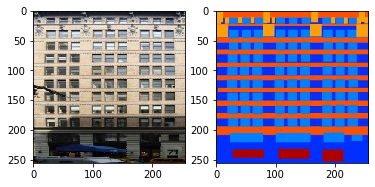

In [5]:
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

def load_dataset(path, shuffle=False):
    # load the images under the folder
    # remember to normalize them to [-1, 1]
    image_names = [name for name in glob.glob(path + '/*.jpg')]
    data = []
    ##########--WRITE YOUR CODE HERE--##########
    for i in image_names:
        img = imageio.imread(i)
        h, w, _ = img.shape     
        _w= int(w/2)
        s_left, s_right = img[:, :_w, :], img[:, _w:, :]
        T = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),
                     (0.5, 0.5, 0.5)),])
        s_left = T(s_left)
        s_right = T(s_right)  

        data.append(s_right)
        data.append(s_left)
    data = [x for x in zip(*[iter(data)]*2)]   
    
    ##########-------END OF CODE-------##########
    # return a list of tuples.
    # for each tuple, the first element is ground truth, the second one is label image
    # both images should be tensors
    return data


set_seeds(302)
train = load_dataset('./facades/train', shuffle=True)
test = load_dataset('./facades/test')
val = load_dataset('./facades/val')


def show_img_pair(s_left, s_right):
    # convert the pixels back to [0, 1] when visualizing
    
    ##########--WRITE YOUR CODE HERE--##########
    s_left = ((s_left +1)*127.5)/255
    s_right = ((s_right +1)*127.5)/255
    s_left = s_left.numpy()
    s_left=s_left.transpose(1,2,0)
    s_right = s_right.numpy()
    s_right=s_right.transpose(1,2, 0)
    
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(s_right)
    
    f.add_subplot(1,2, 2)
    plt.imshow(s_left)
    plt.show(block=True)    
    
    ##########-------END OF CODE-------##########    
    
    
idx = 150
show_img_pair(train[idx][0], train[idx][1])

### Part 2 Models
---
In this part, we will define the network based on the architectures from the paper.
Please check the Appendix of the paper for the details of this architecture.

Let $Ck$ denote a Convolution-BatchNorm-ReLU layer with k filters. $CDk$
denotes a Convolution-BatchNormDropout-ReLU layer with a dropout rate of 50%. All
convolutions are 4 x 4 spatial filters applied with stride 2. Convolutions in the encoder,
and in the discriminator, downsample the input by a factor of 2, whereas in the decoder
they upsample the input by a factor of 2.

#### **{15 points}** (a) Generator
The U-Net encoder-decoder architecture consists of:

U-Net encoder:
$$C64-C128-C256-C512-C512-C512-C512-C512$$

U-Net decoder:

$$CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128$$

After the last layer in the decoder, a convolution is applied to map to the number
of output channels, which is `3` in our problem, followed by a `tanh` function. As a
special case, batch normalization is not applied to the first $C64$ layer in the encoder.
All ReLUs in the encoder are leaky, with slope `0.2`, while ReLUs in the decoder are
not leaky.
If you are not familiar with the architecture of UNet, please check [this paper](https://arxiv.org/abs/1505.04597) first.

#### **{15 points}** (b) Discriminator

The discriminator architecture is:
$$C64-C128-C256-C512$$
After the last layer, a convolution is applied to map to a 1-dimensional output,
followed by a sigmoid function. As an exception to the above notation, batch
normalization is not applied to the first $C64$ layer. All ReLUs are leaky, with slope
`0.2`.

Hint: Use `torch.nn.functional.leaky_relu` for leaky ReLU.

In [6]:
# discriminator
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

class Discriminator(nn.Module):
    def __init__(self, n_channels):
        # n_channels means num of input channels
        super(Discriminator, self).__init__()
        ##########--WRITE YOUR CODE HERE--##########
        d = 64
        self.conv1 = nn.Conv2d(n_channels*2, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 1, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, 1, 4, 1, 1)
        

        ##########-------END OF CODE-------##########
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
        
    def forward(self, inpu, label):
        ##########--WRITE YOUR CODE HERE--##########
#         x = torch.cat([x[0], x[1]], 1)
        x = torch.cat([inpu, label], 1)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x_d = F.sigmoid(self.conv5(x))        
        ##########-------END OF CODE-------##########
        return x_d

##########--WRITE YOUR CODE HERE--##########    
# netD = # initialize the discriminator
netD = Discriminator(3)
# feel free to do some sanity check here

##########-------END OF CODE-------##########    

In [7]:
class GeneratorUNet(nn.Module):
    def __init__(self, n_channels):
        super(GeneratorUNet, self).__init__()
        ##########--WRITE YOUR CODE HERE--##########
        # Unet encoder
        d = 64
        self.conv1 = nn.Conv2d(n_channels, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv5_bn = nn.BatchNorm2d(d * 8)
        self.conv6 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv6_bn = nn.BatchNorm2d(d * 8)
        self.conv7 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv7_bn = nn.BatchNorm2d(d * 8)
        self.conv8 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        
        # Unet decoder
        self.deconv1 = nn.ConvTranspose2d(d * 8, d * 8, 4, 2, 1)
        self.deconv1_bn = nn.BatchNorm2d(d * 8)
        self.deconv2 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d * 8)
        self.deconv3 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d * 8)
        self.deconv4 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d * 8)
        self.deconv5 = nn.ConvTranspose2d(d * 8 * 2, d * 4, 4, 2, 1)
        self.deconv5_bn = nn.BatchNorm2d(d * 4)
        self.deconv6 = nn.ConvTranspose2d(d * 4 * 2, d * 2, 4, 2, 1)
        self.deconv6_bn = nn.BatchNorm2d(d * 2)
        self.deconv7 = nn.ConvTranspose2d(d * 2 * 2, d, 4, 2, 1)
        self.deconv7_bn = nn.BatchNorm2d(d)
        self.deconv8 = nn.ConvTranspose2d(d * 2, 3, 4, 2, 1)
        
        # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

        
        ##########-------END OF CODE-------##########
    
    def forward(self, x):   
        ##########--WRITE YOUR CODE HERE--##########
        e1 = self.conv1(x)
        e2 = self.conv2_bn(self.conv2(F.leaky_relu(e1, 0.2)))
        e3 = self.conv3_bn(self.conv3(F.leaky_relu(e2, 0.2)))
        e4 = self.conv4_bn(self.conv4(F.leaky_relu(e3, 0.2)))
        e5 = self.conv5_bn(self.conv5(F.leaky_relu(e4, 0.2)))
        e6 = self.conv6_bn(self.conv6(F.leaky_relu(e5, 0.2)))
        e7 = self.conv7_bn(self.conv7(F.leaky_relu(e6, 0.2)))
        e8 = self.conv8(F.leaky_relu(e7, 0.2))
        # e8 = self.conv8_bn(self.conv8(F.leaky_relu(e7, 0.2)))
        d1 = F.dropout(self.deconv1_bn(self.deconv1(F.relu(e8))), 0.5, training=True)
        d1 = torch.cat([d1, e7], 1)
        d2 = F.dropout(self.deconv2_bn(self.deconv2(F.relu(d1))), 0.5, training=True)
        d2 = torch.cat([d2, e6], 1)
        d3 = F.dropout(self.deconv3_bn(self.deconv3(F.relu(d2))), 0.5, training=True)
        d3 = torch.cat([d3, e5], 1)
        d4 = self.deconv4_bn(self.deconv4(F.relu(d3)))
        # d4 = F.dropout(self.deconv4_bn(self.deconv4(F.relu(d3))), 0.5)
        d4 = torch.cat([d4, e4], 1)
        d5 = self.deconv5_bn(self.deconv5(F.relu(d4)))
        d5 = torch.cat([d5, e3], 1)
        d6 = self.deconv6_bn(self.deconv6(F.relu(d5)))
        d6 = torch.cat([d6, e2], 1)
        d7 = self.deconv7_bn(self.deconv7(F.relu(d6)))
        d7 = torch.cat([d7, e1], 1)
        d8 = self.deconv8(F.relu(d7))
        x_g = F.tanh(d8)

        
        ##########-------END OF CODE-------##########
        return x_g


##########--WRITE YOUR CODE HERE--##########    
# netG = # initialize the discriminator
netG = GeneratorUNet(3)
netGL1 = GeneratorUNet(3)
# feel free to do some sanity check here

##########-------END OF CODE-------##########  

### Part 3 Optimizor
---
**{5 points}** For optimization, we'll use the Adam optimizer, with a learning rate of `0.0002`, and momentum parameters  $\beta_1= 0.5$; $\beta_2 = 0.999$.

In [8]:
# Define the optimizors here, make sure you give them the right parameters

##########--WRITE YOUR CODE HERE--########## 
optim_G = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_D = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_GL1 = optim.Adam(netGL1.parameters(), lr=0.0002, betas=(0.5, 0.999))

##########-------END OF CODE-------##########

### Part 4 Training
---
**{20 points}** For each batch, first train discriminator D by using the average loss of real image and fake image. Then train generator G by using the following loss equation.
$$G^*=\arg \min_{G} \max_{D} L_{cGAN}(G, D) + \lambda L_{L1}(G) $$

In this homework, you will train two different models: one using only the L1 loss, the other using the equation above with $\lambda = 100$. 

As a sanity check, please compare your results with those in the paper (e.g. Figure 4) to make sure they roughly match.

Train the network for at least 20 epochs (at least 10 epochs for the model with only L1 loss,) but you are encouraged to train longer to obtain better results. (In the paper, they train
for 200 epochs.) Save your models to `pix2pix.pth` and `pix2pixL1.pth` using the given code. 

Note: Training training each epoch should take less than 2 minutes if you are using Colab. **Remember to save your models regularly** so you won't lose your progress accidentally.

**{5 points}** In the end, plot the Generator/Discriminator (G/D) loss history (averaged per epoch) of the two models with respect to the epoch in two plots. i.e. the first plot should contain the G/D loss of the model with L1 and cGAN, the second plot should contain the L1 loss of the other model.


In [9]:
#Creating Dataloader
#loading image by image
from torch.utils.data import Dataset, DataLoader
import PIL
from PIL import Image
def load_image(file):
    img = PIL.Image.open(file)
    img_b = img.crop((0,0,256,256))
    img_a = img.crop((256,0,512,256))
    T = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),
                             (0.5, 0.5, 0.5)),
])
    return T(img_a), T(img_b)

root = 'facades'
class dataset(Dataset):
    def __init__(self, root, mode):
        self.files = glob.glob('%s/%s/*'%(root, mode))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        a, b = load_image(self.files[idx])
        return a, b

train_loader = DataLoader(dataset(root, "train"), 1, shuffle=True)
val_loader = DataLoader(dataset(root, "val"), 1, shuffle=True)

In [10]:
from torchvision.utils import save_image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

netG = netG.to(device)
netD = netD.to(device)
netG.train()
netD.train()

##########--WRITE YOUR CODE HERE--########## 
def train_model(netG, netD, optim_G, optim_D, train_loader, val_loader, epoch):
#     netG.train()
#     netD.train()

    G_loss, D_loss = [], []
    gan_loss = F.binary_cross_entropy_with_logits

    for i, (a, b) in enumerate(train_loader):

        a = a.to(device)
        b = b.to(device)

        real = torch.ones((a.size(0), 1, 30, 30)).to(device)
        fake = torch.zeros((a.size(0), 1, 30, 30)).to(device)

        # update generator

        optim_G.zero_grad()

        fake_b = netG(a)
        pred = netD(a, fake_b)

        loss_G = gan_loss(pred, real) + F.l1_loss(b, fake_b) * 100

        loss_G.backward()
        optim_G.step()

        # update discriminator

        optim_D.zero_grad()

        pred_real = netD(a, b)
        loss_real = gan_loss(pred_real, real)

        pred_fake = netD(a, fake_b.detach())
        loss_fake = gan_loss(pred_fake, fake)

        loss_D = (loss_real + loss_fake) * 0.5

        loss_D.backward()
        optim_D.step()

        G_loss.append(loss_G.item())
        D_loss.append(loss_D.item())

        if (i+1) % 10 == 0:
            g_mean = np.mean(G_loss[-10:])
            d_mean = np.mean(D_loss[-10:])
            print("\rEpoch %d [%d/%d] [G loss: %f] [D loss: %f]" %
                    (epoch, i, len(train_loader), g_mean, d_mean))

        iters = epoch * len(train_loader) + i
        if iters % 500 == 0:
            imgs = []
            for j, (a, b) in enumerate(val_loader):
                a = a.to(device)
                b = b.to(device)
                with torch.no_grad():
                    fake_b = netG(a)
                imgs += [a[0], fake_b[0], b[0]]
                if j == 2:
                    break
            imgs = torch.stack(imgs).detach().cpu()
            save_image(imgs, "images/%s.png"%iters, nrow=3, normalize=True)

    return np.mean(G_loss), np.mean(D_loss)

#performing training
epochs = 200
G_losses = []
D_losses =[]
for epoch in range(epochs):
        G_loss, D_loss = train_model(netG, netD, optim_G, optim_D, train_loader, val_loader, epoch)

        print('\nG_loss: %.4f	D_loss: %.4f\n'%(G_loss, D_loss))
        G_losses.append(G_loss)
        D_losses.append(D_loss)

        with open('log.txt', 'a') as f:
            print('%d\t%.4f\t%.4f'%(epoch, G_loss, D_loss), file=f)

##########-------END OF CODE-------##########

/home/cou/muhammadmonjur.karim/anaconda3/envs/py37/lib/python3.7/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/cou/muhammadmonjur.karim/anaconda3/envs/py37/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0 [9/400] [G loss: 57.173036] [D loss: 0.689311]
Epoch 0 [19/400] [G loss: 48.790394] [D loss: 0.641608]
Epoch 0 [29/400] [G loss: 42.047731] [D loss: 0.635120]
Epoch 0 [39/400] [G loss: 40.455677] [D loss: 0.640074]
Epoch 0 [49/400] [G loss: 40.549157] [D loss: 0.657912]
Epoch 0 [59/400] [G loss: 38.260115] [D loss: 0.656819]
Epoch 0 [69/400] [G loss: 39.928013] [D loss: 0.631590]
Epoch 0 [79/400] [G loss: 39.444700] [D loss: 0.643665]
Epoch 0 [89/400] [G loss: 37.939527] [D loss: 0.626417]
Epoch 0 [99/400] [G loss: 37.048966] [D loss: 0.640715]
Epoch 0 [109/400] [G loss: 39.358179] [D loss: 0.650936]
Epoch 0 [119/400] [G loss: 38.641553] [D loss: 0.650820]
Epoch 0 [129/400] [G loss: 42.971215] [D loss: 0.612149]
Epoch 0 [139/400] [G loss: 35.995369] [D loss: 0.622325]
Epoch 0 [149/400] [G loss: 35.027701] [D loss: 0.600621]
Epoch 0 [159/400] [G loss: 41.178388] [D loss: 0.592604]
Epoch 0 [169/400] [G loss: 38.569505] [D loss: 0.606299]
Epoch 0 [179/400] [G loss: 37.629964] [D l

Epoch 3 [239/400] [G loss: 32.322650] [D loss: 0.552379]
Epoch 3 [249/400] [G loss: 34.962169] [D loss: 0.547269]
Epoch 3 [259/400] [G loss: 35.268301] [D loss: 0.546772]
Epoch 3 [269/400] [G loss: 33.055103] [D loss: 0.531064]
Epoch 3 [279/400] [G loss: 35.152688] [D loss: 0.546104]
Epoch 3 [289/400] [G loss: 35.160764] [D loss: 0.524439]
Epoch 3 [299/400] [G loss: 36.707814] [D loss: 0.519281]
Epoch 3 [309/400] [G loss: 32.863340] [D loss: 0.542785]
Epoch 3 [319/400] [G loss: 33.429524] [D loss: 0.536764]
Epoch 3 [329/400] [G loss: 33.913349] [D loss: 0.526282]
Epoch 3 [339/400] [G loss: 36.366774] [D loss: 0.558391]
Epoch 3 [349/400] [G loss: 36.205697] [D loss: 0.555817]
Epoch 3 [359/400] [G loss: 36.867206] [D loss: 0.556832]
Epoch 3 [369/400] [G loss: 38.212636] [D loss: 0.525240]
Epoch 3 [379/400] [G loss: 35.582893] [D loss: 0.535918]
Epoch 3 [389/400] [G loss: 34.625902] [D loss: 0.546142]
Epoch 3 [399/400] [G loss: 34.390634] [D loss: 0.546889]

G_loss: 35.2555	D_loss: 0.5448

Epoch 7 [69/400] [G loss: 34.472537] [D loss: 0.510130]
Epoch 7 [79/400] [G loss: 32.298673] [D loss: 0.510338]
Epoch 7 [89/400] [G loss: 34.780274] [D loss: 0.503953]
Epoch 7 [99/400] [G loss: 35.117519] [D loss: 0.504550]
Epoch 7 [109/400] [G loss: 31.231265] [D loss: 0.505304]
Epoch 7 [119/400] [G loss: 32.786898] [D loss: 0.503546]
Epoch 7 [129/400] [G loss: 35.099655] [D loss: 0.503555]
Epoch 7 [139/400] [G loss: 33.549623] [D loss: 0.504100]
Epoch 7 [149/400] [G loss: 33.061780] [D loss: 0.504705]
Epoch 7 [159/400] [G loss: 34.841601] [D loss: 0.503825]
Epoch 7 [169/400] [G loss: 34.881297] [D loss: 0.504388]
Epoch 7 [179/400] [G loss: 34.530436] [D loss: 0.503661]
Epoch 7 [189/400] [G loss: 29.841170] [D loss: 0.503508]
Epoch 7 [199/400] [G loss: 33.196575] [D loss: 0.504346]
Epoch 7 [209/400] [G loss: 33.573092] [D loss: 0.503406]
Epoch 7 [219/400] [G loss: 34.789110] [D loss: 0.504162]
Epoch 7 [229/400] [G loss: 34.690001] [D loss: 0.538658]
Epoch 7 [239/400] [G loss: 32.54082

Epoch 10 [299/400] [G loss: 33.857713] [D loss: 0.503307]
Epoch 10 [309/400] [G loss: 33.019513] [D loss: 0.503317]
Epoch 10 [319/400] [G loss: 32.022555] [D loss: 0.503305]
Epoch 10 [329/400] [G loss: 27.435533] [D loss: 0.503257]
Epoch 10 [339/400] [G loss: 33.181583] [D loss: 0.503220]
Epoch 10 [349/400] [G loss: 32.675871] [D loss: 0.503230]
Epoch 10 [359/400] [G loss: 28.621900] [D loss: 0.503614]
Epoch 10 [369/400] [G loss: 30.377525] [D loss: 0.503318]
Epoch 10 [379/400] [G loss: 33.905469] [D loss: 0.503238]
Epoch 10 [389/400] [G loss: 33.240525] [D loss: 0.503391]
Epoch 10 [399/400] [G loss: 34.117727] [D loss: 0.503230]

G_loss: 31.6060	D_loss: 0.5033

Epoch 11 [9/400] [G loss: 28.858224] [D loss: 0.503226]
Epoch 11 [19/400] [G loss: 33.769819] [D loss: 0.503256]
Epoch 11 [29/400] [G loss: 29.296545] [D loss: 0.503302]
Epoch 11 [39/400] [G loss: 30.936099] [D loss: 0.503244]
Epoch 11 [49/400] [G loss: 28.902412] [D loss: 0.503263]
Epoch 11 [59/400] [G loss: 28.719181] [D loss

Epoch 14 [99/400] [G loss: 28.152604] [D loss: 0.503378]
Epoch 14 [109/400] [G loss: 28.881177] [D loss: 0.503239]
Epoch 14 [119/400] [G loss: 26.391060] [D loss: 0.503229]
Epoch 14 [129/400] [G loss: 25.766603] [D loss: 0.503230]
Epoch 14 [139/400] [G loss: 27.632174] [D loss: 0.503221]
Epoch 14 [149/400] [G loss: 28.722547] [D loss: 0.503217]
Epoch 14 [159/400] [G loss: 27.701750] [D loss: 0.503218]
Epoch 14 [169/400] [G loss: 25.075743] [D loss: 0.503251]
Epoch 14 [179/400] [G loss: 28.519455] [D loss: 0.503809]
Epoch 14 [189/400] [G loss: 30.853058] [D loss: 0.503223]
Epoch 14 [199/400] [G loss: 27.843402] [D loss: 0.503410]
Epoch 14 [209/400] [G loss: 28.251013] [D loss: 0.503215]
Epoch 14 [219/400] [G loss: 27.843705] [D loss: 0.503271]
Epoch 14 [229/400] [G loss: 29.198394] [D loss: 0.503239]
Epoch 14 [239/400] [G loss: 27.422717] [D loss: 0.503225]
Epoch 14 [249/400] [G loss: 29.787041] [D loss: 0.503215]
Epoch 14 [259/400] [G loss: 29.502651] [D loss: 0.503236]
Epoch 14 [269/4

Epoch 17 [309/400] [G loss: 25.609645] [D loss: 0.503210]
Epoch 17 [319/400] [G loss: 27.479117] [D loss: 0.503219]
Epoch 17 [329/400] [G loss: 27.412789] [D loss: 0.507725]
Epoch 17 [339/400] [G loss: 26.291607] [D loss: 0.524329]
Epoch 17 [349/400] [G loss: 25.877304] [D loss: 0.505515]
Epoch 17 [359/400] [G loss: 24.949035] [D loss: 0.542993]
Epoch 17 [369/400] [G loss: 28.310104] [D loss: 0.566471]
Epoch 17 [379/400] [G loss: 25.198089] [D loss: 0.548043]
Epoch 17 [389/400] [G loss: 25.239710] [D loss: 0.529794]
Epoch 17 [399/400] [G loss: 26.355784] [D loss: 0.507690]

G_loss: 26.0977	D_loss: 0.5084

Epoch 18 [9/400] [G loss: 26.249067] [D loss: 0.503418]
Epoch 18 [19/400] [G loss: 25.571756] [D loss: 0.503699]
Epoch 18 [29/400] [G loss: 24.984321] [D loss: 0.503263]
Epoch 18 [39/400] [G loss: 24.975134] [D loss: 0.503605]
Epoch 18 [49/400] [G loss: 27.528141] [D loss: 0.503317]
Epoch 18 [59/400] [G loss: 26.651160] [D loss: 0.503249]
Epoch 18 [69/400] [G loss: 26.254074] [D loss:

Epoch 21 [109/400] [G loss: 23.544733] [D loss: 0.503466]
Epoch 21 [119/400] [G loss: 25.436521] [D loss: 0.503239]
Epoch 21 [129/400] [G loss: 26.299305] [D loss: 0.504185]
Epoch 21 [139/400] [G loss: 22.724692] [D loss: 0.503771]
Epoch 21 [149/400] [G loss: 23.791744] [D loss: 0.503299]
Epoch 21 [159/400] [G loss: 26.338503] [D loss: 0.503222]
Epoch 21 [169/400] [G loss: 24.770434] [D loss: 0.503209]
Epoch 21 [179/400] [G loss: 26.126424] [D loss: 0.503241]
Epoch 21 [189/400] [G loss: 24.570115] [D loss: 0.503249]
Epoch 21 [199/400] [G loss: 23.620586] [D loss: 0.503208]
Epoch 21 [209/400] [G loss: 23.239250] [D loss: 0.503227]
Epoch 21 [219/400] [G loss: 27.051102] [D loss: 0.503249]
Epoch 21 [229/400] [G loss: 24.263651] [D loss: 0.503208]
Epoch 21 [239/400] [G loss: 23.580178] [D loss: 0.503239]
Epoch 21 [249/400] [G loss: 22.425766] [D loss: 0.503332]
Epoch 21 [259/400] [G loss: 21.826716] [D loss: 0.503216]
Epoch 21 [269/400] [G loss: 24.015422] [D loss: 0.503227]
Epoch 21 [279/

Epoch 24 [319/400] [G loss: 21.865996] [D loss: 0.503217]
Epoch 24 [329/400] [G loss: 21.479872] [D loss: 0.503209]
Epoch 24 [339/400] [G loss: 22.069665] [D loss: 0.503213]
Epoch 24 [349/400] [G loss: 23.403532] [D loss: 0.503207]
Epoch 24 [359/400] [G loss: 23.056373] [D loss: 0.503208]
Epoch 24 [369/400] [G loss: 23.831078] [D loss: 0.503218]
Epoch 24 [379/400] [G loss: 24.770525] [D loss: 0.503207]
Epoch 24 [389/400] [G loss: 21.986167] [D loss: 0.503206]
Epoch 24 [399/400] [G loss: 22.492016] [D loss: 0.503488]

G_loss: 22.6428	D_loss: 0.5032

Epoch 25 [9/400] [G loss: 21.408120] [D loss: 0.503281]
Epoch 25 [19/400] [G loss: 20.059453] [D loss: 0.503219]
Epoch 25 [29/400] [G loss: 20.383024] [D loss: 0.503306]
Epoch 25 [39/400] [G loss: 24.136720] [D loss: 0.503234]
Epoch 25 [49/400] [G loss: 22.449950] [D loss: 0.503206]
Epoch 25 [59/400] [G loss: 22.366043] [D loss: 0.503207]
Epoch 25 [69/400] [G loss: 23.616738] [D loss: 0.503241]
Epoch 25 [79/400] [G loss: 22.402003] [D loss: 

Epoch 28 [119/400] [G loss: 21.507264] [D loss: 0.503265]
Epoch 28 [129/400] [G loss: 20.450071] [D loss: 0.503206]
Epoch 28 [139/400] [G loss: 20.655864] [D loss: 0.503205]
Epoch 28 [149/400] [G loss: 20.683477] [D loss: 0.503206]
Epoch 28 [159/400] [G loss: 20.050410] [D loss: 0.503209]
Epoch 28 [169/400] [G loss: 20.816395] [D loss: 0.503207]
Epoch 28 [179/400] [G loss: 21.692631] [D loss: 0.503205]
Epoch 28 [189/400] [G loss: 19.854811] [D loss: 0.503208]
Epoch 28 [199/400] [G loss: 21.349316] [D loss: 0.503208]
Epoch 28 [209/400] [G loss: 23.483699] [D loss: 0.503208]
Epoch 28 [219/400] [G loss: 22.033232] [D loss: 0.503205]
Epoch 28 [229/400] [G loss: 21.682139] [D loss: 0.503205]
Epoch 28 [239/400] [G loss: 21.019765] [D loss: 0.503210]
Epoch 28 [249/400] [G loss: 22.536349] [D loss: 0.503205]
Epoch 28 [259/400] [G loss: 21.090458] [D loss: 0.503205]
Epoch 28 [269/400] [G loss: 21.201721] [D loss: 0.503206]
Epoch 28 [279/400] [G loss: 18.548277] [D loss: 0.503205]
Epoch 28 [289/

Epoch 31 [329/400] [G loss: 20.161760] [D loss: 0.535235]
Epoch 31 [339/400] [G loss: 21.294084] [D loss: 0.515555]
Epoch 31 [349/400] [G loss: 19.562985] [D loss: 0.513909]
Epoch 31 [359/400] [G loss: 18.997043] [D loss: 0.513556]
Epoch 31 [369/400] [G loss: 19.695309] [D loss: 0.513574]
Epoch 31 [379/400] [G loss: 20.808526] [D loss: 0.513546]
Epoch 31 [389/400] [G loss: 21.131348] [D loss: 0.514090]
Epoch 31 [399/400] [G loss: 20.399377] [D loss: 0.513555]

G_loss: 20.2534	D_loss: 0.5349

Epoch 32 [9/400] [G loss: 19.036457] [D loss: 0.513809]
Epoch 32 [19/400] [G loss: 18.690091] [D loss: 0.513640]
Epoch 32 [29/400] [G loss: 19.275264] [D loss: 0.513566]
Epoch 32 [39/400] [G loss: 20.134515] [D loss: 0.513663]
Epoch 32 [49/400] [G loss: 19.473478] [D loss: 0.513557]
Epoch 32 [59/400] [G loss: 21.660642] [D loss: 0.513552]
Epoch 32 [69/400] [G loss: 19.972658] [D loss: 0.513837]
Epoch 32 [79/400] [G loss: 19.975694] [D loss: 0.513579]
Epoch 32 [89/400] [G loss: 19.343298] [D loss: 0

Epoch 35 [129/400] [G loss: 18.064613] [D loss: 0.513545]
Epoch 35 [139/400] [G loss: 21.573900] [D loss: 0.513563]
Epoch 35 [149/400] [G loss: 19.605114] [D loss: 0.513540]
Epoch 35 [159/400] [G loss: 21.030215] [D loss: 0.513540]
Epoch 35 [169/400] [G loss: 17.591433] [D loss: 0.513545]
Epoch 35 [179/400] [G loss: 19.059310] [D loss: 0.513541]
Epoch 35 [189/400] [G loss: 16.938110] [D loss: 0.513541]
Epoch 35 [199/400] [G loss: 19.993778] [D loss: 0.513543]
Epoch 35 [209/400] [G loss: 18.330627] [D loss: 0.513541]
Epoch 35 [219/400] [G loss: 20.238247] [D loss: 0.513543]
Epoch 35 [229/400] [G loss: 19.976858] [D loss: 0.513545]
Epoch 35 [239/400] [G loss: 17.893269] [D loss: 0.513541]
Epoch 35 [249/400] [G loss: 19.074564] [D loss: 0.513545]
Epoch 35 [259/400] [G loss: 19.741440] [D loss: 0.513542]
Epoch 35 [269/400] [G loss: 18.067035] [D loss: 0.513541]
Epoch 35 [279/400] [G loss: 18.091531] [D loss: 0.513548]
Epoch 35 [289/400] [G loss: 18.589991] [D loss: 0.513549]
Epoch 35 [299/

Epoch 38 [339/400] [G loss: 18.272758] [D loss: 0.513564]
Epoch 38 [349/400] [G loss: 16.242196] [D loss: 0.513540]
Epoch 38 [359/400] [G loss: 18.336834] [D loss: 0.513671]
Epoch 38 [369/400] [G loss: 18.378074] [D loss: 0.513552]
Epoch 38 [379/400] [G loss: 17.402375] [D loss: 0.513549]
Epoch 38 [389/400] [G loss: 17.581780] [D loss: 0.513573]
Epoch 38 [399/400] [G loss: 20.532855] [D loss: 0.513540]

G_loss: 18.2652	D_loss: 0.5163

Epoch 39 [9/400] [G loss: 17.558785] [D loss: 0.513892]
Epoch 39 [19/400] [G loss: 17.791730] [D loss: 0.513544]
Epoch 39 [29/400] [G loss: 18.020082] [D loss: 0.513545]
Epoch 39 [39/400] [G loss: 17.209848] [D loss: 0.513933]
Epoch 39 [49/400] [G loss: 16.910336] [D loss: 0.513541]
Epoch 39 [59/400] [G loss: 18.256738] [D loss: 0.513745]
Epoch 39 [69/400] [G loss: 16.498006] [D loss: 0.513541]
Epoch 39 [79/400] [G loss: 17.638157] [D loss: 0.513548]
Epoch 39 [89/400] [G loss: 17.348092] [D loss: 0.513540]
Epoch 39 [99/400] [G loss: 17.618975] [D loss: 0.

Epoch 42 [139/400] [G loss: 17.238098] [D loss: 0.513540]
Epoch 42 [149/400] [G loss: 16.489037] [D loss: 0.513668]
Epoch 42 [159/400] [G loss: 19.074944] [D loss: 0.513540]
Epoch 42 [169/400] [G loss: 18.304161] [D loss: 0.513540]
Epoch 42 [179/400] [G loss: 18.426421] [D loss: 0.513541]
Epoch 42 [189/400] [G loss: 17.750817] [D loss: 0.513540]
Epoch 42 [199/400] [G loss: 17.415001] [D loss: 0.513541]
Epoch 42 [209/400] [G loss: 18.446658] [D loss: 0.513540]
Epoch 42 [219/400] [G loss: 17.726957] [D loss: 0.513540]
Epoch 42 [229/400] [G loss: 17.238977] [D loss: 0.513541]
Epoch 42 [239/400] [G loss: 18.661569] [D loss: 0.513540]
Epoch 42 [249/400] [G loss: 16.594282] [D loss: 0.513542]
Epoch 42 [259/400] [G loss: 15.991831] [D loss: 0.513540]
Epoch 42 [269/400] [G loss: 15.238672] [D loss: 0.513540]
Epoch 42 [279/400] [G loss: 16.657308] [D loss: 0.513540]
Epoch 42 [289/400] [G loss: 18.102248] [D loss: 0.514264]
Epoch 42 [299/400] [G loss: 17.354263] [D loss: 0.513542]
Epoch 42 [309/

Epoch 45 [349/400] [G loss: 15.843385] [D loss: 0.513541]
Epoch 45 [359/400] [G loss: 18.232740] [D loss: 0.513579]
Epoch 45 [369/400] [G loss: 16.056159] [D loss: 0.513540]
Epoch 45 [379/400] [G loss: 17.020863] [D loss: 0.513541]
Epoch 45 [389/400] [G loss: 15.916229] [D loss: 0.513540]
Epoch 45 [399/400] [G loss: 17.364307] [D loss: 0.513546]

G_loss: 16.8674	D_loss: 0.5137

Epoch 46 [9/400] [G loss: 16.077107] [D loss: 0.513540]
Epoch 46 [19/400] [G loss: 16.727244] [D loss: 0.513547]
Epoch 46 [29/400] [G loss: 18.084111] [D loss: 0.513540]
Epoch 46 [39/400] [G loss: 16.072575] [D loss: 0.513545]
Epoch 46 [49/400] [G loss: 17.281095] [D loss: 0.513540]
Epoch 46 [59/400] [G loss: 16.951603] [D loss: 0.513542]
Epoch 46 [69/400] [G loss: 17.226800] [D loss: 0.513541]
Epoch 46 [79/400] [G loss: 17.353290] [D loss: 0.513540]
Epoch 46 [89/400] [G loss: 16.848098] [D loss: 0.513540]
Epoch 46 [99/400] [G loss: 17.098682] [D loss: 0.513541]
Epoch 46 [109/400] [G loss: 16.190318] [D loss: 0.

Epoch 49 [149/400] [G loss: 15.291384] [D loss: 0.513541]
Epoch 49 [159/400] [G loss: 17.434959] [D loss: 0.513540]
Epoch 49 [169/400] [G loss: 16.398467] [D loss: 0.513546]
Epoch 49 [179/400] [G loss: 16.559547] [D loss: 0.513540]
Epoch 49 [189/400] [G loss: 14.454451] [D loss: 0.513540]
Epoch 49 [199/400] [G loss: 17.400130] [D loss: 0.513540]
Epoch 49 [209/400] [G loss: 16.215378] [D loss: 0.513540]
Epoch 49 [219/400] [G loss: 15.085657] [D loss: 0.513541]
Epoch 49 [229/400] [G loss: 17.310450] [D loss: 0.513540]
Epoch 49 [239/400] [G loss: 17.230921] [D loss: 0.513540]
Epoch 49 [249/400] [G loss: 16.114649] [D loss: 0.513540]
Epoch 49 [259/400] [G loss: 15.407951] [D loss: 0.513540]
Epoch 49 [269/400] [G loss: 16.130294] [D loss: 0.513540]
Epoch 49 [279/400] [G loss: 16.315761] [D loss: 0.513540]
Epoch 49 [289/400] [G loss: 16.082390] [D loss: 0.513540]
Epoch 49 [299/400] [G loss: 16.988945] [D loss: 0.513540]
Epoch 49 [309/400] [G loss: 15.531376] [D loss: 0.513540]
Epoch 49 [319/

Epoch 52 [359/400] [G loss: 14.628061] [D loss: 0.513540]
Epoch 52 [369/400] [G loss: 14.992592] [D loss: 0.513540]
Epoch 52 [379/400] [G loss: 15.880167] [D loss: 0.513540]
Epoch 52 [389/400] [G loss: 15.929349] [D loss: 0.513540]
Epoch 52 [399/400] [G loss: 17.593881] [D loss: 0.513540]

G_loss: 15.5822	D_loss: 0.5135

Epoch 53 [9/400] [G loss: 16.085857] [D loss: 0.513540]
Epoch 53 [19/400] [G loss: 15.866295] [D loss: 0.513540]
Epoch 53 [29/400] [G loss: 15.179661] [D loss: 0.513540]
Epoch 53 [39/400] [G loss: 15.685491] [D loss: 0.513540]
Epoch 53 [49/400] [G loss: 14.043978] [D loss: 0.513540]
Epoch 53 [59/400] [G loss: 14.833798] [D loss: 0.513540]
Epoch 53 [69/400] [G loss: 15.957792] [D loss: 0.513540]
Epoch 53 [79/400] [G loss: 14.202980] [D loss: 0.513540]
Epoch 53 [89/400] [G loss: 14.809107] [D loss: 0.513540]
Epoch 53 [99/400] [G loss: 15.467443] [D loss: 0.513540]
Epoch 53 [109/400] [G loss: 15.076314] [D loss: 0.513540]
Epoch 53 [119/400] [G loss: 15.602589] [D loss: 0.

Epoch 56 [159/400] [G loss: 14.061621] [D loss: 0.513540]
Epoch 56 [169/400] [G loss: 13.321237] [D loss: 0.513542]
Epoch 56 [179/400] [G loss: 14.318688] [D loss: 0.513541]
Epoch 56 [189/400] [G loss: 14.753791] [D loss: 0.513540]
Epoch 56 [199/400] [G loss: 15.084016] [D loss: 0.513540]
Epoch 56 [209/400] [G loss: 14.899383] [D loss: 0.513540]
Epoch 56 [219/400] [G loss: 15.418090] [D loss: 0.513804]
Epoch 56 [229/400] [G loss: 14.128815] [D loss: 0.513541]
Epoch 56 [239/400] [G loss: 15.087276] [D loss: 0.513541]
Epoch 56 [249/400] [G loss: 15.206184] [D loss: 0.513540]
Epoch 56 [259/400] [G loss: 14.935854] [D loss: 0.513540]
Epoch 56 [269/400] [G loss: 14.124698] [D loss: 0.513540]
Epoch 56 [279/400] [G loss: 15.269840] [D loss: 0.513540]
Epoch 56 [289/400] [G loss: 15.045242] [D loss: 0.513540]
Epoch 56 [299/400] [G loss: 14.853645] [D loss: 0.513540]
Epoch 56 [309/400] [G loss: 14.891548] [D loss: 0.513540]
Epoch 56 [319/400] [G loss: 15.325848] [D loss: 0.513544]
Epoch 56 [329/

Epoch 59 [369/400] [G loss: 13.397140] [D loss: 0.513540]
Epoch 59 [379/400] [G loss: 14.787014] [D loss: 0.513540]
Epoch 59 [389/400] [G loss: 14.116572] [D loss: 0.513540]
Epoch 59 [399/400] [G loss: 14.263520] [D loss: 0.513488]

G_loss: 14.3948	D_loss: 0.5135

Epoch 60 [9/400] [G loss: 13.648563] [D loss: 0.513541]
Epoch 60 [19/400] [G loss: 13.579631] [D loss: 0.513541]
Epoch 60 [29/400] [G loss: 13.820072] [D loss: 0.513540]
Epoch 60 [39/400] [G loss: 14.304102] [D loss: 0.513540]
Epoch 60 [49/400] [G loss: 14.954711] [D loss: 0.513540]
Epoch 60 [59/400] [G loss: 13.289380] [D loss: 0.513540]
Epoch 60 [69/400] [G loss: 15.311837] [D loss: 0.513540]
Epoch 60 [79/400] [G loss: 15.222094] [D loss: 0.513540]
Epoch 60 [89/400] [G loss: 13.788959] [D loss: 0.513542]
Epoch 60 [99/400] [G loss: 14.616447] [D loss: 0.513540]
Epoch 60 [109/400] [G loss: 13.000488] [D loss: 0.513540]
Epoch 60 [119/400] [G loss: 14.654916] [D loss: 0.513564]
Epoch 60 [129/400] [G loss: 15.284770] [D loss: 0.

Epoch 63 [169/400] [G loss: 14.724114] [D loss: 0.517669]
Epoch 63 [179/400] [G loss: 13.824308] [D loss: 0.563077]
Epoch 63 [189/400] [G loss: 14.087969] [D loss: 0.514767]
Epoch 63 [199/400] [G loss: 13.017642] [D loss: 0.573787]
Epoch 63 [209/400] [G loss: 13.967253] [D loss: 0.526463]
Epoch 63 [219/400] [G loss: 14.045060] [D loss: 0.543318]
Epoch 63 [229/400] [G loss: 12.817859] [D loss: 0.530751]
Epoch 63 [239/400] [G loss: 14.571947] [D loss: 0.515176]
Epoch 63 [249/400] [G loss: 15.049953] [D loss: 0.513558]
Epoch 63 [259/400] [G loss: 12.912046] [D loss: 0.514244]
Epoch 63 [269/400] [G loss: 14.200824] [D loss: 0.513541]
Epoch 63 [279/400] [G loss: 14.916083] [D loss: 0.513981]
Epoch 63 [289/400] [G loss: 14.817005] [D loss: 0.513560]
Epoch 63 [299/400] [G loss: 14.417929] [D loss: 0.524413]
Epoch 63 [309/400] [G loss: 14.029399] [D loss: 0.514018]
Epoch 63 [319/400] [G loss: 13.907956] [D loss: 0.515282]
Epoch 63 [329/400] [G loss: 15.076576] [D loss: 0.514305]
Epoch 63 [339/

Epoch 66 [379/400] [G loss: 13.199712] [D loss: 0.513587]
Epoch 66 [389/400] [G loss: 13.412003] [D loss: 0.513541]
Epoch 66 [399/400] [G loss: 13.770677] [D loss: 0.513540]

G_loss: 13.5360	D_loss: 0.5136

Epoch 67 [9/400] [G loss: 13.946816] [D loss: 0.513540]
Epoch 67 [19/400] [G loss: 13.926603] [D loss: 0.513541]
Epoch 67 [29/400] [G loss: 13.315919] [D loss: 0.513541]
Epoch 67 [39/400] [G loss: 13.625661] [D loss: 0.513541]
Epoch 67 [49/400] [G loss: 14.691136] [D loss: 0.513540]
Epoch 67 [59/400] [G loss: 12.728145] [D loss: 0.513570]
Epoch 67 [69/400] [G loss: 13.431268] [D loss: 0.513545]
Epoch 67 [79/400] [G loss: 13.305151] [D loss: 0.513615]
Epoch 67 [89/400] [G loss: 13.501574] [D loss: 0.513541]
Epoch 67 [99/400] [G loss: 14.916896] [D loss: 0.513542]
Epoch 67 [109/400] [G loss: 12.555152] [D loss: 0.513584]
Epoch 67 [119/400] [G loss: 13.435396] [D loss: 0.513541]
Epoch 67 [129/400] [G loss: 12.338330] [D loss: 0.513544]
Epoch 67 [139/400] [G loss: 13.494308] [D loss: 0.

Epoch 70 [179/400] [G loss: 12.098908] [D loss: 0.513579]
Epoch 70 [189/400] [G loss: 13.671342] [D loss: 0.513540]
Epoch 70 [199/400] [G loss: 13.277165] [D loss: 0.513553]
Epoch 70 [209/400] [G loss: 12.917599] [D loss: 0.513540]
Epoch 70 [219/400] [G loss: 12.345052] [D loss: 0.513541]
Epoch 70 [229/400] [G loss: 12.699239] [D loss: 0.513540]
Epoch 70 [239/400] [G loss: 14.065922] [D loss: 0.513540]
Epoch 70 [249/400] [G loss: 14.322429] [D loss: 0.513540]
Epoch 70 [259/400] [G loss: 13.297340] [D loss: 0.513541]
Epoch 70 [269/400] [G loss: 12.866091] [D loss: 0.513540]
Epoch 70 [279/400] [G loss: 12.779928] [D loss: 0.513540]
Epoch 70 [289/400] [G loss: 12.919306] [D loss: 0.513540]
Epoch 70 [299/400] [G loss: 12.844286] [D loss: 0.513541]
Epoch 70 [309/400] [G loss: 13.606642] [D loss: 0.513546]
Epoch 70 [319/400] [G loss: 12.747071] [D loss: 0.513540]
Epoch 70 [329/400] [G loss: 13.055999] [D loss: 0.513546]
Epoch 70 [339/400] [G loss: 12.574811] [D loss: 0.513540]
Epoch 70 [349/

Epoch 73 [389/400] [G loss: 12.061562] [D loss: 0.513540]
Epoch 73 [399/400] [G loss: 12.687059] [D loss: 0.513540]

G_loss: 12.8599	D_loss: 0.5135

Epoch 74 [9/400] [G loss: 14.622082] [D loss: 0.513540]
Epoch 74 [19/400] [G loss: 12.419673] [D loss: 0.513540]
Epoch 74 [29/400] [G loss: 12.272174] [D loss: 0.513552]
Epoch 74 [39/400] [G loss: 12.610594] [D loss: 0.513540]
Epoch 74 [49/400] [G loss: 12.984492] [D loss: 0.513540]
Epoch 74 [59/400] [G loss: 13.473381] [D loss: 0.513540]
Epoch 74 [69/400] [G loss: 13.265307] [D loss: 0.513540]
Epoch 74 [79/400] [G loss: 11.954986] [D loss: 0.513540]
Epoch 74 [89/400] [G loss: 12.531333] [D loss: 0.513540]
Epoch 74 [99/400] [G loss: 12.490277] [D loss: 0.513540]
Epoch 74 [109/400] [G loss: 13.008503] [D loss: 0.513540]
Epoch 74 [119/400] [G loss: 12.435984] [D loss: 0.513540]
Epoch 74 [129/400] [G loss: 12.903891] [D loss: 0.513540]
Epoch 74 [139/400] [G loss: 12.285628] [D loss: 0.513540]
Epoch 74 [149/400] [G loss: 13.719057] [D loss: 0.

Epoch 77 [189/400] [G loss: 11.975984] [D loss: 0.513348]
Epoch 77 [199/400] [G loss: 11.939967] [D loss: 0.513540]
Epoch 77 [209/400] [G loss: 12.241941] [D loss: 0.513544]
Epoch 77 [219/400] [G loss: 11.943887] [D loss: 0.513540]
Epoch 77 [229/400] [G loss: 11.536638] [D loss: 0.513540]
Epoch 77 [239/400] [G loss: 12.303345] [D loss: 0.513593]
Epoch 77 [249/400] [G loss: 11.164683] [D loss: 0.513541]
Epoch 77 [259/400] [G loss: 12.670529] [D loss: 0.513542]
Epoch 77 [269/400] [G loss: 11.669658] [D loss: 0.537530]
Epoch 77 [279/400] [G loss: 13.265316] [D loss: 0.539094]
Epoch 77 [289/400] [G loss: 13.251867] [D loss: 0.542766]
Epoch 77 [299/400] [G loss: 12.690245] [D loss: 0.514909]
Epoch 77 [309/400] [G loss: 13.262151] [D loss: 0.513768]
Epoch 77 [319/400] [G loss: 12.604554] [D loss: 0.532782]
Epoch 77 [329/400] [G loss: 12.521419] [D loss: 0.554094]
Epoch 77 [339/400] [G loss: 12.410765] [D loss: 0.525866]
Epoch 77 [349/400] [G loss: 12.122388] [D loss: 0.548061]
Epoch 77 [359/

Epoch 80 [399/400] [G loss: 12.106808] [D loss: 0.513546]

G_loss: 12.2224	D_loss: 0.5153

Epoch 81 [9/400] [G loss: 11.446422] [D loss: 0.513540]
Epoch 81 [19/400] [G loss: 11.699234] [D loss: 0.513540]
Epoch 81 [29/400] [G loss: 12.945287] [D loss: 0.513544]
Epoch 81 [39/400] [G loss: 12.348704] [D loss: 0.513540]
Epoch 81 [49/400] [G loss: 12.002905] [D loss: 0.513675]
Epoch 81 [59/400] [G loss: 12.494888] [D loss: 0.513541]
Epoch 81 [69/400] [G loss: 13.260013] [D loss: 0.513550]
Epoch 81 [79/400] [G loss: 13.639128] [D loss: 0.513541]
Epoch 81 [89/400] [G loss: 12.689126] [D loss: 0.513548]
Epoch 81 [99/400] [G loss: 11.786276] [D loss: 0.513543]
Epoch 81 [109/400] [G loss: 11.626090] [D loss: 0.513655]
Epoch 81 [119/400] [G loss: 11.997111] [D loss: 0.513540]
Epoch 81 [129/400] [G loss: 12.623034] [D loss: 0.513682]
Epoch 81 [139/400] [G loss: 12.036955] [D loss: 0.513540]
Epoch 81 [149/400] [G loss: 11.890309] [D loss: 0.513540]
Epoch 81 [159/400] [G loss: 12.059070] [D loss: 0.

Epoch 84 [199/400] [G loss: 11.448917] [D loss: 0.513540]
Epoch 84 [209/400] [G loss: 12.629488] [D loss: 0.513549]
Epoch 84 [219/400] [G loss: 12.378533] [D loss: 0.513540]
Epoch 84 [229/400] [G loss: 11.968974] [D loss: 0.513371]
Epoch 84 [239/400] [G loss: 12.049818] [D loss: 0.513540]
Epoch 84 [249/400] [G loss: 13.262524] [D loss: 0.513551]
Epoch 84 [259/400] [G loss: 12.257233] [D loss: 0.513540]
Epoch 84 [269/400] [G loss: 11.318418] [D loss: 0.513540]
Epoch 84 [279/400] [G loss: 10.290297] [D loss: 0.513541]
Epoch 84 [289/400] [G loss: 12.470324] [D loss: 0.513548]
Epoch 84 [299/400] [G loss: 12.427444] [D loss: 0.513540]
Epoch 84 [309/400] [G loss: 11.789875] [D loss: 0.513543]
Epoch 84 [319/400] [G loss: 11.905727] [D loss: 0.513540]
Epoch 84 [329/400] [G loss: 11.693655] [D loss: 0.513541]
Epoch 84 [339/400] [G loss: 11.266331] [D loss: 0.513540]
Epoch 84 [349/400] [G loss: 11.910840] [D loss: 0.513541]
Epoch 84 [359/400] [G loss: 12.884117] [D loss: 0.513540]
Epoch 84 [369/

Epoch 88 [9/400] [G loss: 11.043117] [D loss: 0.513590]
Epoch 88 [19/400] [G loss: 12.300375] [D loss: 0.513540]
Epoch 88 [29/400] [G loss: 11.843305] [D loss: 0.513541]
Epoch 88 [39/400] [G loss: 12.404786] [D loss: 0.513540]
Epoch 88 [49/400] [G loss: 12.789086] [D loss: 0.513540]
Epoch 88 [59/400] [G loss: 11.197077] [D loss: 0.513540]
Epoch 88 [69/400] [G loss: 11.304336] [D loss: 0.513542]
Epoch 88 [79/400] [G loss: 11.578547] [D loss: 0.513542]
Epoch 88 [89/400] [G loss: 11.249081] [D loss: 0.513541]
Epoch 88 [99/400] [G loss: 12.428016] [D loss: 0.513540]
Epoch 88 [109/400] [G loss: 11.383760] [D loss: 0.513540]
Epoch 88 [119/400] [G loss: 12.437462] [D loss: 0.513540]
Epoch 88 [129/400] [G loss: 11.126651] [D loss: 0.513540]
Epoch 88 [139/400] [G loss: 10.914758] [D loss: 0.513540]
Epoch 88 [149/400] [G loss: 12.546187] [D loss: 0.513542]
Epoch 88 [159/400] [G loss: 11.186679] [D loss: 0.513540]
Epoch 88 [169/400] [G loss: 10.560334] [D loss: 0.513540]
Epoch 88 [179/400] [G los

Epoch 91 [219/400] [G loss: 10.239494] [D loss: 0.513541]
Epoch 91 [229/400] [G loss: 11.297871] [D loss: 0.513540]
Epoch 91 [239/400] [G loss: 10.790156] [D loss: 0.513540]
Epoch 91 [249/400] [G loss: 11.420868] [D loss: 0.513540]
Epoch 91 [259/400] [G loss: 11.129685] [D loss: 0.513540]
Epoch 91 [269/400] [G loss: 11.012583] [D loss: 0.513540]
Epoch 91 [279/400] [G loss: 10.268996] [D loss: 0.513540]
Epoch 91 [289/400] [G loss: 12.738243] [D loss: 0.513540]
Epoch 91 [299/400] [G loss: 11.740907] [D loss: 0.513540]
Epoch 91 [309/400] [G loss: 11.325919] [D loss: 0.513540]
Epoch 91 [319/400] [G loss: 11.507413] [D loss: 0.513540]
Epoch 91 [329/400] [G loss: 11.437031] [D loss: 0.513540]
Epoch 91 [339/400] [G loss: 10.736158] [D loss: 0.513542]
Epoch 91 [349/400] [G loss: 10.916564] [D loss: 0.513540]
Epoch 91 [359/400] [G loss: 11.429205] [D loss: 0.513541]
Epoch 91 [369/400] [G loss: 10.907069] [D loss: 0.513540]
Epoch 91 [379/400] [G loss: 11.409345] [D loss: 0.513540]
Epoch 91 [389/

Epoch 95 [19/400] [G loss: 10.466954] [D loss: 0.513540]
Epoch 95 [29/400] [G loss: 11.607644] [D loss: 0.513540]
Epoch 95 [39/400] [G loss: 11.029702] [D loss: 0.513540]
Epoch 95 [49/400] [G loss: 11.959807] [D loss: 0.513540]
Epoch 95 [59/400] [G loss: 11.040395] [D loss: 0.513540]
Epoch 95 [69/400] [G loss: 10.686912] [D loss: 0.513540]
Epoch 95 [79/400] [G loss: 11.541250] [D loss: 0.513541]
Epoch 95 [89/400] [G loss: 10.289487] [D loss: 0.513540]
Epoch 95 [99/400] [G loss: 10.033809] [D loss: 0.513540]
Epoch 95 [109/400] [G loss: 11.557441] [D loss: 0.513540]
Epoch 95 [119/400] [G loss: 10.425897] [D loss: 0.513540]
Epoch 95 [129/400] [G loss: 12.101536] [D loss: 0.513540]
Epoch 95 [139/400] [G loss: 11.446533] [D loss: 0.513540]
Epoch 95 [149/400] [G loss: 11.264591] [D loss: 0.513540]
Epoch 95 [159/400] [G loss: 9.982569] [D loss: 0.513540]
Epoch 95 [169/400] [G loss: 11.610180] [D loss: 0.513540]
Epoch 95 [179/400] [G loss: 11.416100] [D loss: 0.513540]
Epoch 95 [189/400] [G lo

Epoch 98 [229/400] [G loss: 10.877844] [D loss: 0.513540]
Epoch 98 [239/400] [G loss: 10.909643] [D loss: 0.513540]
Epoch 98 [249/400] [G loss: 10.294378] [D loss: 0.513540]
Epoch 98 [259/400] [G loss: 10.907251] [D loss: 0.513540]
Epoch 98 [269/400] [G loss: 11.211277] [D loss: 0.513540]
Epoch 98 [279/400] [G loss: 10.912741] [D loss: 0.513540]
Epoch 98 [289/400] [G loss: 10.234788] [D loss: 0.513541]
Epoch 98 [299/400] [G loss: 11.788436] [D loss: 0.513540]
Epoch 98 [309/400] [G loss: 11.406528] [D loss: 0.513540]
Epoch 98 [319/400] [G loss: 10.314450] [D loss: 0.513540]
Epoch 98 [329/400] [G loss: 10.289794] [D loss: 0.513540]
Epoch 98 [339/400] [G loss: 10.422419] [D loss: 0.513540]
Epoch 98 [349/400] [G loss: 10.883302] [D loss: 0.513549]
Epoch 98 [359/400] [G loss: 10.510620] [D loss: 0.513541]
Epoch 98 [369/400] [G loss: 11.132931] [D loss: 0.513540]
Epoch 98 [379/400] [G loss: 11.198512] [D loss: 0.513540]
Epoch 98 [389/400] [G loss: 10.445843] [D loss: 0.513541]
Epoch 98 [399/

Epoch 102 [19/400] [G loss: 11.052426] [D loss: 0.513540]
Epoch 102 [29/400] [G loss: 10.264026] [D loss: 0.513540]
Epoch 102 [39/400] [G loss: 11.085944] [D loss: 0.513540]
Epoch 102 [49/400] [G loss: 10.441410] [D loss: 0.513540]
Epoch 102 [59/400] [G loss: 10.865162] [D loss: 0.513540]
Epoch 102 [69/400] [G loss: 10.021223] [D loss: 0.513542]
Epoch 102 [79/400] [G loss: 10.484333] [D loss: 0.513545]
Epoch 102 [89/400] [G loss: 11.581980] [D loss: 0.513540]
Epoch 102 [99/400] [G loss: 10.660233] [D loss: 0.513540]
Epoch 102 [109/400] [G loss: 10.663464] [D loss: 0.513310]
Epoch 102 [119/400] [G loss: 10.725732] [D loss: 0.513540]
Epoch 102 [129/400] [G loss: 11.260351] [D loss: 0.513540]
Epoch 102 [139/400] [G loss: 10.788691] [D loss: 0.513540]
Epoch 102 [149/400] [G loss: 10.372254] [D loss: 0.513540]
Epoch 102 [159/400] [G loss: 11.212918] [D loss: 0.513540]
Epoch 102 [169/400] [G loss: 10.943510] [D loss: 0.513540]
Epoch 102 [179/400] [G loss: 10.142979] [D loss: 0.513540]
Epoch 

Epoch 105 [209/400] [G loss: 11.121228] [D loss: 0.513542]
Epoch 105 [219/400] [G loss: 9.761001] [D loss: 0.514092]
Epoch 105 [229/400] [G loss: 10.237536] [D loss: 0.513564]
Epoch 105 [239/400] [G loss: 9.157388] [D loss: 0.513540]
Epoch 105 [249/400] [G loss: 10.802017] [D loss: 0.513552]
Epoch 105 [259/400] [G loss: 9.884858] [D loss: 0.513540]
Epoch 105 [269/400] [G loss: 9.634047] [D loss: 0.513542]
Epoch 105 [279/400] [G loss: 10.228711] [D loss: 0.513635]
Epoch 105 [289/400] [G loss: 11.225982] [D loss: 0.513540]
Epoch 105 [299/400] [G loss: 9.939591] [D loss: 0.513583]
Epoch 105 [309/400] [G loss: 10.897028] [D loss: 0.516804]
Epoch 105 [319/400] [G loss: 11.602329] [D loss: 0.529912]
Epoch 105 [329/400] [G loss: 10.965965] [D loss: 0.514589]
Epoch 105 [339/400] [G loss: 10.580815] [D loss: 0.513605]
Epoch 105 [349/400] [G loss: 9.555742] [D loss: 0.513552]
Epoch 105 [359/400] [G loss: 10.441595] [D loss: 0.513540]
Epoch 105 [369/400] [G loss: 10.109130] [D loss: 0.513566]
Epo

Epoch 108 [399/400] [G loss: 10.852138] [D loss: 0.513594]

G_loss: 10.4956	D_loss: 0.5140

Epoch 109 [9/400] [G loss: 9.690554] [D loss: 0.513742]
Epoch 109 [19/400] [G loss: 10.724074] [D loss: 0.513540]
Epoch 109 [29/400] [G loss: 11.083625] [D loss: 0.513823]
Epoch 109 [39/400] [G loss: 10.601998] [D loss: 0.513541]
Epoch 109 [49/400] [G loss: 10.085223] [D loss: 0.513542]
Epoch 109 [59/400] [G loss: 10.198457] [D loss: 0.513540]
Epoch 109 [69/400] [G loss: 10.595399] [D loss: 0.513541]
Epoch 109 [79/400] [G loss: 10.174406] [D loss: 0.513540]
Epoch 109 [89/400] [G loss: 11.245724] [D loss: 0.513548]
Epoch 109 [99/400] [G loss: 9.965926] [D loss: 0.513579]
Epoch 109 [109/400] [G loss: 11.028797] [D loss: 0.513541]
Epoch 109 [119/400] [G loss: 10.165931] [D loss: 0.513541]
Epoch 109 [129/400] [G loss: 10.202289] [D loss: 0.513540]
Epoch 109 [139/400] [G loss: 11.250814] [D loss: 0.513540]
Epoch 109 [149/400] [G loss: 10.203400] [D loss: 0.513546]
Epoch 109 [159/400] [G loss: 10.5441

Epoch 112 [179/400] [G loss: 9.109371] [D loss: 0.513540]
Epoch 112 [189/400] [G loss: 10.119937] [D loss: 0.513540]
Epoch 112 [199/400] [G loss: 11.490446] [D loss: 0.513540]
Epoch 112 [209/400] [G loss: 11.105063] [D loss: 0.513540]
Epoch 112 [219/400] [G loss: 10.071699] [D loss: 0.513540]
Epoch 112 [229/400] [G loss: 10.437624] [D loss: 0.513540]
Epoch 112 [239/400] [G loss: 9.987458] [D loss: 0.513540]
Epoch 112 [249/400] [G loss: 10.358796] [D loss: 0.513540]
Epoch 112 [259/400] [G loss: 10.743273] [D loss: 0.513541]
Epoch 112 [269/400] [G loss: 9.970777] [D loss: 0.513550]
Epoch 112 [279/400] [G loss: 9.879745] [D loss: 0.513540]
Epoch 112 [289/400] [G loss: 10.363255] [D loss: 0.513540]
Epoch 112 [299/400] [G loss: 10.755146] [D loss: 0.513540]
Epoch 112 [309/400] [G loss: 10.118753] [D loss: 0.513540]
Epoch 112 [319/400] [G loss: 10.404345] [D loss: 0.513540]
Epoch 112 [329/400] [G loss: 10.050496] [D loss: 0.513540]
Epoch 112 [339/400] [G loss: 10.585350] [D loss: 0.513540]
E

Epoch 115 [369/400] [G loss: 10.074026] [D loss: 0.705392]
Epoch 115 [379/400] [G loss: 10.565918] [D loss: 0.697128]
Epoch 115 [389/400] [G loss: 11.581404] [D loss: 0.694487]
Epoch 115 [399/400] [G loss: 9.985512] [D loss: 0.694621]

G_loss: 10.2251	D_loss: 0.5405

Epoch 116 [9/400] [G loss: 9.391662] [D loss: 0.690295]
Epoch 116 [19/400] [G loss: 9.543307] [D loss: 0.690781]
Epoch 116 [29/400] [G loss: 9.448770] [D loss: 0.690813]
Epoch 116 [39/400] [G loss: 9.968637] [D loss: 0.680176]
Epoch 116 [49/400] [G loss: 10.318166] [D loss: 0.666030]
Epoch 116 [59/400] [G loss: 10.081716] [D loss: 0.664693]
Epoch 116 [69/400] [G loss: 10.067154] [D loss: 0.629977]
Epoch 116 [79/400] [G loss: 9.435504] [D loss: 0.608368]
Epoch 116 [89/400] [G loss: 11.563075] [D loss: 0.583779]
Epoch 116 [99/400] [G loss: 9.849661] [D loss: 0.549028]
Epoch 116 [109/400] [G loss: 10.839111] [D loss: 0.525393]
Epoch 116 [119/400] [G loss: 11.300064] [D loss: 0.518132]
Epoch 116 [129/400] [G loss: 10.108426] [

Epoch 119 [159/400] [G loss: 9.381325] [D loss: 0.516022]
Epoch 119 [169/400] [G loss: 10.024933] [D loss: 0.536970]
Epoch 119 [179/400] [G loss: 9.739815] [D loss: 0.748075]
Epoch 119 [189/400] [G loss: 10.621022] [D loss: 0.697168]
Epoch 119 [199/400] [G loss: 9.899016] [D loss: 0.693838]
Epoch 119 [209/400] [G loss: 9.609439] [D loss: 0.692510]
Epoch 119 [219/400] [G loss: 10.063181] [D loss: 0.696569]
Epoch 119 [229/400] [G loss: 9.885574] [D loss: 0.678696]
Epoch 119 [239/400] [G loss: 11.013049] [D loss: 0.692802]
Epoch 119 [249/400] [G loss: 9.459325] [D loss: 0.640934]
Epoch 119 [259/400] [G loss: 9.646336] [D loss: 0.595440]
Epoch 119 [269/400] [G loss: 9.091179] [D loss: 0.564434]
Epoch 119 [279/400] [G loss: 9.045904] [D loss: 0.579124]
Epoch 119 [289/400] [G loss: 10.852776] [D loss: 0.712755]
Epoch 119 [299/400] [G loss: 9.825919] [D loss: 0.585640]
Epoch 119 [309/400] [G loss: 9.870525] [D loss: 0.540251]
Epoch 119 [319/400] [G loss: 9.501596] [D loss: 0.539121]
Epoch 119

Epoch 122 [359/400] [G loss: 10.286351] [D loss: 0.514620]
Epoch 122 [369/400] [G loss: 10.067654] [D loss: 0.513561]
Epoch 122 [379/400] [G loss: 9.989215] [D loss: 0.513840]
Epoch 122 [389/400] [G loss: 9.701974] [D loss: 0.513819]
Epoch 122 [399/400] [G loss: 9.558496] [D loss: 0.518158]

G_loss: 9.8614	D_loss: 0.5360

Epoch 123 [9/400] [G loss: 10.210912] [D loss: 0.527529]
Epoch 123 [19/400] [G loss: 9.062850] [D loss: 0.513745]
Epoch 123 [29/400] [G loss: 11.284249] [D loss: 0.539889]
Epoch 123 [39/400] [G loss: 9.825798] [D loss: 0.513935]
Epoch 123 [49/400] [G loss: 10.021565] [D loss: 0.539607]
Epoch 123 [59/400] [G loss: 10.406319] [D loss: 0.565650]
Epoch 123 [69/400] [G loss: 9.155774] [D loss: 0.516492]
Epoch 123 [79/400] [G loss: 11.098947] [D loss: 0.549329]
Epoch 123 [89/400] [G loss: 10.123204] [D loss: 0.572630]
Epoch 123 [99/400] [G loss: 9.540939] [D loss: 0.534418]
Epoch 123 [109/400] [G loss: 10.608329] [D loss: 0.554572]
Epoch 123 [119/400] [G loss: 10.124987] [D

Epoch 126 [149/400] [G loss: 10.054681] [D loss: 0.546389]
Epoch 126 [159/400] [G loss: 9.245129] [D loss: 0.523572]
Epoch 126 [169/400] [G loss: 10.616781] [D loss: 0.543523]
Epoch 126 [179/400] [G loss: 10.019571] [D loss: 0.513566]
Epoch 126 [189/400] [G loss: 9.505961] [D loss: 0.513698]
Epoch 126 [199/400] [G loss: 11.010313] [D loss: 0.551914]
Epoch 126 [209/400] [G loss: 9.097678] [D loss: 0.521159]
Epoch 126 [219/400] [G loss: 9.654901] [D loss: 0.543516]
Epoch 126 [229/400] [G loss: 9.534679] [D loss: 0.514630]
Epoch 126 [239/400] [G loss: 9.876293] [D loss: 0.545480]
Epoch 126 [249/400] [G loss: 10.227914] [D loss: 0.574332]
Epoch 126 [259/400] [G loss: 9.265405] [D loss: 0.513554]
Epoch 126 [269/400] [G loss: 9.771640] [D loss: 0.523472]
Epoch 126 [279/400] [G loss: 10.601902] [D loss: 0.681375]
Epoch 126 [289/400] [G loss: 10.247996] [D loss: 0.585519]
Epoch 126 [299/400] [G loss: 9.675471] [D loss: 0.514104]
Epoch 126 [309/400] [G loss: 8.816278] [D loss: 0.519183]
Epoch 1

Epoch 129 [349/400] [G loss: 8.995302] [D loss: 0.538516]
Epoch 129 [359/400] [G loss: 9.360158] [D loss: 0.540519]
Epoch 129 [369/400] [G loss: 8.930480] [D loss: 0.513868]
Epoch 129 [379/400] [G loss: 8.932115] [D loss: 0.612808]
Epoch 129 [389/400] [G loss: 9.731161] [D loss: 0.525240]
Epoch 129 [399/400] [G loss: 9.611405] [D loss: 0.552798]

G_loss: 9.5013	D_loss: 0.5266

Epoch 130 [9/400] [G loss: 9.693176] [D loss: 0.514970]
Epoch 130 [19/400] [G loss: 9.485867] [D loss: 0.514308]
Epoch 130 [29/400] [G loss: 10.445204] [D loss: 0.513714]
Epoch 130 [39/400] [G loss: 9.538572] [D loss: 0.537647]
Epoch 130 [49/400] [G loss: 9.427856] [D loss: 0.528389]
Epoch 130 [59/400] [G loss: 9.003624] [D loss: 0.514128]
Epoch 130 [69/400] [G loss: 9.597501] [D loss: 0.556270]
Epoch 130 [79/400] [G loss: 9.093446] [D loss: 0.523347]
Epoch 130 [89/400] [G loss: 9.890076] [D loss: 0.534883]
Epoch 130 [99/400] [G loss: 9.907840] [D loss: 0.560244]
Epoch 130 [109/400] [G loss: 9.469500] [D loss: 0.

Epoch 133 [149/400] [G loss: 9.946858] [D loss: 0.513540]
Epoch 133 [159/400] [G loss: 8.911328] [D loss: 0.594961]
Epoch 133 [169/400] [G loss: 10.361061] [D loss: 0.520243]
Epoch 133 [179/400] [G loss: 9.412806] [D loss: 0.556650]
Epoch 133 [189/400] [G loss: 9.801538] [D loss: 0.525901]
Epoch 133 [199/400] [G loss: 9.738864] [D loss: 0.526022]
Epoch 133 [209/400] [G loss: 9.884900] [D loss: 0.548820]
Epoch 133 [219/400] [G loss: 9.625304] [D loss: 0.543246]
Epoch 133 [229/400] [G loss: 9.406097] [D loss: 0.513541]
Epoch 133 [239/400] [G loss: 9.447109] [D loss: 0.513675]
Epoch 133 [249/400] [G loss: 9.330213] [D loss: 0.513550]
Epoch 133 [259/400] [G loss: 8.953677] [D loss: 0.578771]
Epoch 133 [269/400] [G loss: 8.978785] [D loss: 0.530534]
Epoch 133 [279/400] [G loss: 9.851519] [D loss: 0.513592]
Epoch 133 [289/400] [G loss: 9.016438] [D loss: 0.516224]
Epoch 133 [299/400] [G loss: 9.024227] [D loss: 0.532135]
Epoch 133 [309/400] [G loss: 9.184253] [D loss: 0.513543]
Epoch 133 [31

Epoch 136 [349/400] [G loss: 9.536071] [D loss: 0.513579]
Epoch 136 [359/400] [G loss: 8.731563] [D loss: 0.513550]
Epoch 136 [369/400] [G loss: 8.271755] [D loss: 0.513690]
Epoch 136 [379/400] [G loss: 8.825336] [D loss: 0.513542]
Epoch 136 [389/400] [G loss: 9.845159] [D loss: 0.514241]
Epoch 136 [399/400] [G loss: 8.966617] [D loss: 0.515255]

G_loss: 9.2981	D_loss: 0.5167

Epoch 137 [9/400] [G loss: 8.872189] [D loss: 0.517602]
Epoch 137 [19/400] [G loss: 9.522935] [D loss: 0.513599]
Epoch 137 [29/400] [G loss: 8.926642] [D loss: 0.513633]
Epoch 137 [39/400] [G loss: 9.962379] [D loss: 0.526972]
Epoch 137 [49/400] [G loss: 9.384637] [D loss: 0.513601]
Epoch 137 [59/400] [G loss: 9.767085] [D loss: 0.528530]
Epoch 137 [69/400] [G loss: 9.955608] [D loss: 0.515663]
Epoch 137 [79/400] [G loss: 8.539464] [D loss: 0.513730]
Epoch 137 [89/400] [G loss: 9.824744] [D loss: 0.516364]
Epoch 137 [99/400] [G loss: 9.243109] [D loss: 0.543516]
Epoch 137 [109/400] [G loss: 9.735979] [D loss: 0.5

Epoch 140 [149/400] [G loss: 9.749297] [D loss: 0.513578]
Epoch 140 [159/400] [G loss: 9.810192] [D loss: 0.513540]
Epoch 140 [169/400] [G loss: 8.012437] [D loss: 0.519019]
Epoch 140 [179/400] [G loss: 9.647292] [D loss: 0.724976]
Epoch 140 [189/400] [G loss: 8.752445] [D loss: 0.677347]
Epoch 140 [199/400] [G loss: 8.990354] [D loss: 0.589030]
Epoch 140 [209/400] [G loss: 8.428046] [D loss: 0.530562]
Epoch 140 [219/400] [G loss: 9.177338] [D loss: 0.534983]
Epoch 140 [229/400] [G loss: 8.951024] [D loss: 0.557377]
Epoch 140 [239/400] [G loss: 9.254647] [D loss: 0.516066]
Epoch 140 [249/400] [G loss: 9.161223] [D loss: 0.513620]
Epoch 140 [259/400] [G loss: 9.682523] [D loss: 0.513642]
Epoch 140 [269/400] [G loss: 8.962479] [D loss: 0.513684]
Epoch 140 [279/400] [G loss: 9.246502] [D loss: 0.530739]
Epoch 140 [289/400] [G loss: 9.232287] [D loss: 0.536384]
Epoch 140 [299/400] [G loss: 9.211166] [D loss: 0.513544]
Epoch 140 [309/400] [G loss: 10.130608] [D loss: 0.513953]
Epoch 140 [31

Epoch 143 [359/400] [G loss: 9.465810] [D loss: 0.513559]
Epoch 143 [369/400] [G loss: 8.988300] [D loss: 0.513713]
Epoch 143 [379/400] [G loss: 8.477035] [D loss: 0.515166]
Epoch 143 [389/400] [G loss: 8.338926] [D loss: 0.526872]
Epoch 143 [399/400] [G loss: 8.180115] [D loss: 0.536596]

G_loss: 9.0714	D_loss: 0.5150

Epoch 144 [9/400] [G loss: 9.514743] [D loss: 0.514614]
Epoch 144 [19/400] [G loss: 9.432479] [D loss: 0.513540]
Epoch 144 [29/400] [G loss: 10.105007] [D loss: 0.513540]
Epoch 144 [39/400] [G loss: 8.727883] [D loss: 0.513706]
Epoch 144 [49/400] [G loss: 8.722859] [D loss: 0.513540]
Epoch 144 [59/400] [G loss: 9.200493] [D loss: 0.513540]
Epoch 144 [69/400] [G loss: 9.023485] [D loss: 0.513540]
Epoch 144 [79/400] [G loss: 8.746533] [D loss: 0.527162]
Epoch 144 [89/400] [G loss: 8.230576] [D loss: 0.513595]
Epoch 144 [99/400] [G loss: 8.719527] [D loss: 0.513541]
Epoch 144 [109/400] [G loss: 8.117940] [D loss: 0.513544]
Epoch 144 [119/400] [G loss: 8.530357] [D loss: 0.

Epoch 147 [159/400] [G loss: 8.992462] [D loss: 0.513540]
Epoch 147 [169/400] [G loss: 9.143160] [D loss: 0.513540]
Epoch 147 [179/400] [G loss: 8.923347] [D loss: 0.513540]
Epoch 147 [189/400] [G loss: 10.368212] [D loss: 0.513594]
Epoch 147 [199/400] [G loss: 8.936341] [D loss: 0.513543]
Epoch 147 [209/400] [G loss: 9.575746] [D loss: 0.513540]
Epoch 147 [219/400] [G loss: 8.657803] [D loss: 0.513540]
Epoch 147 [229/400] [G loss: 8.248683] [D loss: 0.513540]
Epoch 147 [239/400] [G loss: 8.964445] [D loss: 0.513540]
Epoch 147 [249/400] [G loss: 8.381833] [D loss: 0.513540]
Epoch 147 [259/400] [G loss: 8.593041] [D loss: 0.513540]
Epoch 147 [269/400] [G loss: 9.533382] [D loss: 0.513540]
Epoch 147 [279/400] [G loss: 9.110686] [D loss: 0.513553]
Epoch 147 [289/400] [G loss: 8.608207] [D loss: 0.513545]
Epoch 147 [299/400] [G loss: 8.319655] [D loss: 0.513562]
Epoch 147 [309/400] [G loss: 9.179643] [D loss: 0.513540]
Epoch 147 [319/400] [G loss: 8.792125] [D loss: 0.513547]
Epoch 147 [32

Epoch 150 [369/400] [G loss: 8.013939] [D loss: 0.513540]
Epoch 150 [379/400] [G loss: 8.388483] [D loss: 0.513540]
Epoch 150 [389/400] [G loss: 9.420018] [D loss: 0.513540]
Epoch 150 [399/400] [G loss: 9.097007] [D loss: 0.513541]

G_loss: 8.8590	D_loss: 0.5135

Epoch 151 [9/400] [G loss: 9.367764] [D loss: 0.513540]
Epoch 151 [19/400] [G loss: 8.299333] [D loss: 0.513541]
Epoch 151 [29/400] [G loss: 8.763502] [D loss: 0.513540]
Epoch 151 [39/400] [G loss: 9.873026] [D loss: 0.513540]
Epoch 151 [49/400] [G loss: 9.578194] [D loss: 0.513540]
Epoch 151 [59/400] [G loss: 8.595959] [D loss: 0.513540]
Epoch 151 [69/400] [G loss: 8.482058] [D loss: 0.513541]
Epoch 151 [79/400] [G loss: 8.541999] [D loss: 0.513540]
Epoch 151 [89/400] [G loss: 8.535277] [D loss: 0.513540]
Epoch 151 [99/400] [G loss: 8.424577] [D loss: 0.513540]
Epoch 151 [109/400] [G loss: 9.076243] [D loss: 0.513540]
Epoch 151 [119/400] [G loss: 9.181837] [D loss: 0.513540]
Epoch 151 [129/400] [G loss: 9.020246] [D loss: 0.5

Epoch 154 [169/400] [G loss: 9.085800] [D loss: 0.533639]
Epoch 154 [179/400] [G loss: 8.446050] [D loss: 0.514702]
Epoch 154 [189/400] [G loss: 8.983466] [D loss: 0.514726]
Epoch 154 [199/400] [G loss: 9.697468] [D loss: 0.513587]
Epoch 154 [209/400] [G loss: 8.136565] [D loss: 0.513551]
Epoch 154 [219/400] [G loss: 8.559505] [D loss: 0.538229]
Epoch 154 [229/400] [G loss: 9.236217] [D loss: 0.513804]
Epoch 154 [239/400] [G loss: 8.898216] [D loss: 0.513672]
Epoch 154 [249/400] [G loss: 9.406823] [D loss: 0.513541]
Epoch 154 [259/400] [G loss: 8.522488] [D loss: 0.513541]
Epoch 154 [269/400] [G loss: 8.470228] [D loss: 0.513547]
Epoch 154 [279/400] [G loss: 8.469446] [D loss: 0.513575]
Epoch 154 [289/400] [G loss: 8.761038] [D loss: 0.513540]
Epoch 154 [299/400] [G loss: 8.885499] [D loss: 0.513542]
Epoch 154 [309/400] [G loss: 8.741645] [D loss: 0.513567]
Epoch 154 [319/400] [G loss: 9.500712] [D loss: 0.513558]
Epoch 154 [329/400] [G loss: 8.198811] [D loss: 0.513542]
Epoch 154 [339

Epoch 157 [379/400] [G loss: 7.934692] [D loss: 0.513543]
Epoch 157 [389/400] [G loss: 8.351316] [D loss: 0.514690]
Epoch 157 [399/400] [G loss: 8.469286] [D loss: 0.513559]

G_loss: 8.6678	D_loss: 0.5154

Epoch 158 [9/400] [G loss: 8.240406] [D loss: 0.513541]
Epoch 158 [19/400] [G loss: 7.821231] [D loss: 0.513540]
Epoch 158 [29/400] [G loss: 8.629103] [D loss: 0.513540]
Epoch 158 [39/400] [G loss: 8.687948] [D loss: 0.513540]
Epoch 158 [49/400] [G loss: 8.503785] [D loss: 0.513541]
Epoch 158 [59/400] [G loss: 8.573461] [D loss: 0.513540]
Epoch 158 [69/400] [G loss: 8.499294] [D loss: 0.513542]
Epoch 158 [79/400] [G loss: 8.777610] [D loss: 0.513540]
Epoch 158 [89/400] [G loss: 9.239774] [D loss: 0.513545]
Epoch 158 [99/400] [G loss: 8.807402] [D loss: 0.513541]
Epoch 158 [109/400] [G loss: 9.367499] [D loss: 0.513540]
Epoch 158 [119/400] [G loss: 8.156833] [D loss: 0.513540]
Epoch 158 [129/400] [G loss: 9.085871] [D loss: 0.513540]
Epoch 158 [139/400] [G loss: 8.224268] [D loss: 0.5

Epoch 161 [179/400] [G loss: 8.899581] [D loss: 0.520793]
Epoch 161 [189/400] [G loss: 7.772202] [D loss: 0.513557]
Epoch 161 [199/400] [G loss: 8.197509] [D loss: 0.514190]
Epoch 161 [209/400] [G loss: 8.233503] [D loss: 0.537173]
Epoch 161 [219/400] [G loss: 8.582517] [D loss: 0.514621]
Epoch 161 [229/400] [G loss: 8.671271] [D loss: 0.528344]
Epoch 161 [239/400] [G loss: 8.379573] [D loss: 0.513597]
Epoch 161 [249/400] [G loss: 9.012450] [D loss: 0.513672]
Epoch 161 [259/400] [G loss: 8.831239] [D loss: 0.513545]
Epoch 161 [269/400] [G loss: 9.420367] [D loss: 0.513541]
Epoch 161 [279/400] [G loss: 8.866444] [D loss: 0.513540]
Epoch 161 [289/400] [G loss: 8.538817] [D loss: 0.513541]
Epoch 161 [299/400] [G loss: 7.976436] [D loss: 0.513540]
Epoch 161 [309/400] [G loss: 8.633546] [D loss: 0.513546]
Epoch 161 [319/400] [G loss: 8.327044] [D loss: 0.513541]
Epoch 161 [329/400] [G loss: 7.867618] [D loss: 0.513540]
Epoch 161 [339/400] [G loss: 7.946207] [D loss: 0.513682]
Epoch 161 [349

Epoch 164 [389/400] [G loss: 8.475389] [D loss: 0.513540]
Epoch 164 [399/400] [G loss: 8.082859] [D loss: 0.513540]

G_loss: 8.4748	D_loss: 0.5135

Epoch 165 [9/400] [G loss: 8.304966] [D loss: 0.513546]
Epoch 165 [19/400] [G loss: 8.432283] [D loss: 0.513541]
Epoch 165 [29/400] [G loss: 8.343358] [D loss: 0.513540]
Epoch 165 [39/400] [G loss: 8.780204] [D loss: 0.513541]
Epoch 165 [49/400] [G loss: 8.922425] [D loss: 0.513541]
Epoch 165 [59/400] [G loss: 8.378468] [D loss: 0.513540]
Epoch 165 [69/400] [G loss: 8.219141] [D loss: 0.513541]
Epoch 165 [79/400] [G loss: 9.031100] [D loss: 0.513540]
Epoch 165 [89/400] [G loss: 8.658136] [D loss: 0.513541]
Epoch 165 [99/400] [G loss: 8.663853] [D loss: 0.513552]
Epoch 165 [109/400] [G loss: 8.562614] [D loss: 0.513540]
Epoch 165 [119/400] [G loss: 7.926574] [D loss: 0.513540]
Epoch 165 [129/400] [G loss: 8.121278] [D loss: 0.513540]
Epoch 165 [139/400] [G loss: 9.248419] [D loss: 0.513540]
Epoch 165 [149/400] [G loss: 8.212853] [D loss: 0.5

Epoch 168 [189/400] [G loss: 8.214178] [D loss: 0.513540]
Epoch 168 [199/400] [G loss: 8.557359] [D loss: 0.513540]
Epoch 168 [209/400] [G loss: 7.823118] [D loss: 0.513542]
Epoch 168 [219/400] [G loss: 7.806318] [D loss: 0.513540]
Epoch 168 [229/400] [G loss: 8.054071] [D loss: 0.513540]
Epoch 168 [239/400] [G loss: 8.284490] [D loss: 0.513540]
Epoch 168 [249/400] [G loss: 7.664388] [D loss: 0.513540]
Epoch 168 [259/400] [G loss: 7.741242] [D loss: 0.513540]
Epoch 168 [269/400] [G loss: 9.042712] [D loss: 0.513541]
Epoch 168 [279/400] [G loss: 8.864938] [D loss: 0.513540]
Epoch 168 [289/400] [G loss: 8.521156] [D loss: 0.513541]
Epoch 168 [299/400] [G loss: 8.590061] [D loss: 0.513541]
Epoch 168 [309/400] [G loss: 8.653266] [D loss: 0.513545]
Epoch 168 [319/400] [G loss: 8.021056] [D loss: 0.513540]
Epoch 168 [329/400] [G loss: 7.684807] [D loss: 0.513540]
Epoch 168 [339/400] [G loss: 8.131764] [D loss: 0.513540]
Epoch 168 [349/400] [G loss: 7.742208] [D loss: 0.513540]
Epoch 168 [359

Epoch 171 [399/400] [G loss: 7.820443] [D loss: 0.513540]

G_loss: 8.2784	D_loss: 0.5135

Epoch 172 [9/400] [G loss: 8.090462] [D loss: 0.513540]
Epoch 172 [19/400] [G loss: 8.158119] [D loss: 0.513540]
Epoch 172 [29/400] [G loss: 9.067933] [D loss: 0.513540]
Epoch 172 [39/400] [G loss: 8.346295] [D loss: 0.513540]
Epoch 172 [49/400] [G loss: 8.710794] [D loss: 0.513542]
Epoch 172 [59/400] [G loss: 7.688203] [D loss: 0.513540]
Epoch 172 [69/400] [G loss: 7.906204] [D loss: 0.513540]
Epoch 172 [79/400] [G loss: 8.995757] [D loss: 0.513541]
Epoch 172 [89/400] [G loss: 8.173339] [D loss: 0.513540]
Epoch 172 [99/400] [G loss: 7.785452] [D loss: 0.513541]
Epoch 172 [109/400] [G loss: 8.688580] [D loss: 0.513541]
Epoch 172 [119/400] [G loss: 8.063932] [D loss: 0.513540]
Epoch 172 [129/400] [G loss: 8.567217] [D loss: 0.513540]
Epoch 172 [139/400] [G loss: 8.432812] [D loss: 0.513540]
Epoch 172 [149/400] [G loss: 8.083361] [D loss: 0.513543]
Epoch 172 [159/400] [G loss: 8.267364] [D loss: 0.5

Epoch 175 [199/400] [G loss: 8.157727] [D loss: 0.513541]
Epoch 175 [209/400] [G loss: 8.249895] [D loss: 0.513540]
Epoch 175 [219/400] [G loss: 8.499261] [D loss: 0.513543]
Epoch 175 [229/400] [G loss: 8.243142] [D loss: 0.513540]
Epoch 175 [239/400] [G loss: 8.427436] [D loss: 0.513540]
Epoch 175 [249/400] [G loss: 7.578957] [D loss: 0.513540]
Epoch 175 [259/400] [G loss: 7.827134] [D loss: 0.513540]
Epoch 175 [269/400] [G loss: 8.518146] [D loss: 0.513540]
Epoch 175 [279/400] [G loss: 8.203645] [D loss: 0.513540]
Epoch 175 [289/400] [G loss: 8.326570] [D loss: 0.513540]
Epoch 175 [299/400] [G loss: 7.731688] [D loss: 0.513540]
Epoch 175 [309/400] [G loss: 8.537949] [D loss: 0.513540]
Epoch 175 [319/400] [G loss: 8.945164] [D loss: 0.513541]
Epoch 175 [329/400] [G loss: 7.603750] [D loss: 0.513540]
Epoch 175 [339/400] [G loss: 7.664980] [D loss: 0.513540]
Epoch 175 [349/400] [G loss: 8.431241] [D loss: 0.513540]
Epoch 175 [359/400] [G loss: 8.801251] [D loss: 0.513543]
Epoch 175 [369

Epoch 179 [9/400] [G loss: 7.840665] [D loss: 0.534276]
Epoch 179 [19/400] [G loss: 8.999273] [D loss: 0.519558]
Epoch 179 [29/400] [G loss: 8.346870] [D loss: 0.520279]
Epoch 179 [39/400] [G loss: 6.971856] [D loss: 0.536157]
Epoch 179 [49/400] [G loss: 7.529770] [D loss: 0.559810]
Epoch 179 [59/400] [G loss: 7.721995] [D loss: 0.515559]
Epoch 179 [69/400] [G loss: 8.904638] [D loss: 0.535862]
Epoch 179 [79/400] [G loss: 8.666998] [D loss: 0.535410]
Epoch 179 [89/400] [G loss: 8.229195] [D loss: 0.514063]
Epoch 179 [99/400] [G loss: 8.392598] [D loss: 0.513678]
Epoch 179 [109/400] [G loss: 7.558582] [D loss: 0.513557]
Epoch 179 [119/400] [G loss: 7.870564] [D loss: 0.514750]
Epoch 179 [129/400] [G loss: 7.835781] [D loss: 0.513865]
Epoch 179 [139/400] [G loss: 7.946457] [D loss: 0.513720]
Epoch 179 [149/400] [G loss: 7.982286] [D loss: 0.570255]
Epoch 179 [159/400] [G loss: 8.713906] [D loss: 0.686457]
Epoch 179 [169/400] [G loss: 8.168093] [D loss: 0.575146]
Epoch 179 [179/400] [G lo

Epoch 182 [219/400] [G loss: 7.812073] [D loss: 0.513540]
Epoch 182 [229/400] [G loss: 8.065216] [D loss: 0.513540]
Epoch 182 [239/400] [G loss: 8.669040] [D loss: 0.513540]
Epoch 182 [249/400] [G loss: 7.687746] [D loss: 0.513540]
Epoch 182 [259/400] [G loss: 7.076710] [D loss: 0.513540]
Epoch 182 [269/400] [G loss: 7.780201] [D loss: 0.513540]
Epoch 182 [279/400] [G loss: 7.800687] [D loss: 0.513541]
Epoch 182 [289/400] [G loss: 8.120999] [D loss: 0.513540]
Epoch 182 [299/400] [G loss: 8.710228] [D loss: 0.513540]
Epoch 182 [309/400] [G loss: 7.994694] [D loss: 0.513544]
Epoch 182 [319/400] [G loss: 8.029149] [D loss: 0.513541]
Epoch 182 [329/400] [G loss: 7.769738] [D loss: 0.513570]
Epoch 182 [339/400] [G loss: 7.558075] [D loss: 0.513550]
Epoch 182 [349/400] [G loss: 8.360249] [D loss: 0.513540]
Epoch 182 [359/400] [G loss: 7.413636] [D loss: 0.517320]
Epoch 182 [369/400] [G loss: 7.588123] [D loss: 0.570967]
Epoch 182 [379/400] [G loss: 7.968407] [D loss: 0.516892]
Epoch 182 [389

Epoch 186 [19/400] [G loss: 9.491723] [D loss: 0.513540]
Epoch 186 [29/400] [G loss: 7.994392] [D loss: 0.513540]
Epoch 186 [39/400] [G loss: 8.314338] [D loss: 0.513540]
Epoch 186 [49/400] [G loss: 7.997739] [D loss: 0.513540]
Epoch 186 [59/400] [G loss: 8.455433] [D loss: 0.513645]
Epoch 186 [69/400] [G loss: 9.066669] [D loss: 0.513540]
Epoch 186 [79/400] [G loss: 8.496725] [D loss: 0.513541]
Epoch 186 [89/400] [G loss: 8.213756] [D loss: 0.513540]
Epoch 186 [99/400] [G loss: 7.772937] [D loss: 0.513764]
Epoch 186 [109/400] [G loss: 7.370174] [D loss: 0.513667]
Epoch 186 [119/400] [G loss: 7.444084] [D loss: 0.513540]
Epoch 186 [129/400] [G loss: 8.205222] [D loss: 0.513542]
Epoch 186 [139/400] [G loss: 7.892895] [D loss: 0.513540]
Epoch 186 [149/400] [G loss: 7.443923] [D loss: 0.513540]
Epoch 186 [159/400] [G loss: 7.777165] [D loss: 0.513540]
Epoch 186 [169/400] [G loss: 7.974646] [D loss: 0.513540]
Epoch 186 [179/400] [G loss: 8.692023] [D loss: 0.513543]
Epoch 186 [189/400] [G 

Epoch 189 [229/400] [G loss: 7.187706] [D loss: 0.513540]
Epoch 189 [239/400] [G loss: 7.664624] [D loss: 0.513540]
Epoch 189 [249/400] [G loss: 7.363494] [D loss: 0.513540]
Epoch 189 [259/400] [G loss: 7.948160] [D loss: 0.513540]
Epoch 189 [269/400] [G loss: 7.963204] [D loss: 0.513540]
Epoch 189 [279/400] [G loss: 7.681947] [D loss: 0.513540]
Epoch 189 [289/400] [G loss: 7.795766] [D loss: 0.513540]
Epoch 189 [299/400] [G loss: 8.052883] [D loss: 0.513641]
Epoch 189 [309/400] [G loss: 7.655982] [D loss: 0.513540]
Epoch 189 [319/400] [G loss: 7.723272] [D loss: 0.513541]
Epoch 189 [329/400] [G loss: 8.110761] [D loss: 0.513540]
Epoch 189 [339/400] [G loss: 8.596447] [D loss: 0.513540]
Epoch 189 [349/400] [G loss: 8.372450] [D loss: 0.513540]
Epoch 189 [359/400] [G loss: 7.818759] [D loss: 0.513541]
Epoch 189 [369/400] [G loss: 8.271073] [D loss: 0.513541]
Epoch 189 [379/400] [G loss: 7.813255] [D loss: 0.513542]
Epoch 189 [389/400] [G loss: 7.784275] [D loss: 0.513540]
Epoch 189 [399

Epoch 193 [29/400] [G loss: 7.148998] [D loss: 0.513540]
Epoch 193 [39/400] [G loss: 7.670553] [D loss: 0.513541]
Epoch 193 [49/400] [G loss: 8.121409] [D loss: 0.513540]
Epoch 193 [59/400] [G loss: 8.685842] [D loss: 0.513540]
Epoch 193 [69/400] [G loss: 7.747020] [D loss: 0.513540]
Epoch 193 [79/400] [G loss: 7.601789] [D loss: 0.513540]
Epoch 193 [89/400] [G loss: 8.633617] [D loss: 0.513540]
Epoch 193 [99/400] [G loss: 6.904790] [D loss: 0.513541]
Epoch 193 [109/400] [G loss: 7.669917] [D loss: 0.513540]
Epoch 193 [119/400] [G loss: 7.491737] [D loss: 0.513542]
Epoch 193 [129/400] [G loss: 8.804077] [D loss: 0.513541]
Epoch 193 [139/400] [G loss: 8.332920] [D loss: 0.513540]
Epoch 193 [149/400] [G loss: 8.153718] [D loss: 0.513540]
Epoch 193 [159/400] [G loss: 7.315984] [D loss: 0.513540]
Epoch 193 [169/400] [G loss: 7.078556] [D loss: 0.513540]
Epoch 193 [179/400] [G loss: 7.631711] [D loss: 0.513540]
Epoch 193 [189/400] [G loss: 7.368638] [D loss: 0.513543]
Epoch 193 [199/400] [G

Epoch 196 [239/400] [G loss: 7.055267] [D loss: 0.513540]
Epoch 196 [249/400] [G loss: 7.292753] [D loss: 0.513540]
Epoch 196 [259/400] [G loss: 7.350580] [D loss: 0.513540]
Epoch 196 [269/400] [G loss: 8.054220] [D loss: 0.543480]
Epoch 196 [279/400] [G loss: 8.887555] [D loss: 0.513540]
Epoch 196 [289/400] [G loss: 7.886185] [D loss: 0.527135]
Epoch 196 [299/400] [G loss: 7.036016] [D loss: 0.538699]
Epoch 196 [309/400] [G loss: 7.377471] [D loss: 0.515592]
Epoch 196 [319/400] [G loss: 7.888774] [D loss: 0.513542]
Epoch 196 [329/400] [G loss: 7.772364] [D loss: 0.516057]
Epoch 196 [339/400] [G loss: 7.531015] [D loss: 0.513545]
Epoch 196 [349/400] [G loss: 7.550788] [D loss: 0.513735]
Epoch 196 [359/400] [G loss: 7.959655] [D loss: 0.515408]
Epoch 196 [369/400] [G loss: 7.915222] [D loss: 0.513540]
Epoch 196 [379/400] [G loss: 7.220094] [D loss: 0.542988]
Epoch 196 [389/400] [G loss: 7.845901] [D loss: 0.530432]
Epoch 196 [399/400] [G loss: 8.177572] [D loss: 0.513688]

G_loss: 7.770

In [11]:
netGL1 = netGL1.to(device)
netGL1.train()

##########--WRITE YOUR CODE HERE--########## 
def train_model(netGL1, optim_G, train_loader, val_loader, epoch):
#     netG.train()
#     netD.train()

    GL1_loss = []
#     gan_loss = F.binary_cross_entropy_with_logits

    for i, (a, b) in enumerate(train_loader):

        a = a.to(device)
        b = b.to(device)

        real = torch.ones((a.size(0), 1, 30, 30)).to(device)
        fake = torch.zeros((a.size(0), 1, 30, 30)).to(device)

        # update generator

        optim_G.zero_grad()

        fake_b = netGL1(a)
#         pred = netD(a, fake_b)

#         loss_G = gan_loss(pred, real) + F.l1_loss(b, fake_b) * 100
        loss_G = F.l1_loss(b, fake_b)

        loss_G.backward()
        optim_GL1.step()


        GL1_loss.append(loss_G.item())
#         D_loss.append(loss_D.item())

        if (i+1) % 10 == 0:
            g_mean = np.mean(GL1_loss[-10:])
            print("\rEpoch %d [%d/%d] [GL1 loss: %f]" %
                    (epoch, i, len(train_loader), g_mean))

        iters = epoch * len(train_loader) + i
        if iters % 500 == 0:
            imgs = []
            for j, (a, b) in enumerate(val_loader):
                a = a.to(device)
                b = b.to(device)
                with torch.no_grad():
                    fake_b = netGL1(a)
                imgs += [a[0], fake_b[0], b[0]]
                if j == 2:
                    break
            imgs = torch.stack(imgs).detach().cpu()
            save_image(imgs, "images_l1/%s.png"%iters, nrow=3, normalize=True)

    return np.mean(GL1_loss)

epoch_l1 = 150
GL1_losses = []
for epoch in range(epoch_l1):
        GL1_loss = train_model(netGL1, optim_G, train_loader, val_loader, epoch)

        print('\nGL1_loss: %.4f \n'%(GL1_loss))
        GL1_losses.append(GL1_loss)

        with open('logL1.txt', 'a') as f:
            print('%d\t%.4f\t'%(epoch, GL1_loss), file=f)


##########-------END OF CODE-------##########

Epoch 0 [9/400] [GL1 loss: 0.541952]
Epoch 0 [19/400] [GL1 loss: 0.477163]
Epoch 0 [29/400] [GL1 loss: 0.452320]
Epoch 0 [39/400] [GL1 loss: 0.471283]
Epoch 0 [49/400] [GL1 loss: 0.467252]
Epoch 0 [59/400] [GL1 loss: 0.424090]
Epoch 0 [69/400] [GL1 loss: 0.497036]
Epoch 0 [79/400] [GL1 loss: 0.422862]
Epoch 0 [89/400] [GL1 loss: 0.413996]
Epoch 0 [99/400] [GL1 loss: 0.408546]
Epoch 0 [109/400] [GL1 loss: 0.480368]
Epoch 0 [119/400] [GL1 loss: 0.432125]
Epoch 0 [129/400] [GL1 loss: 0.435719]
Epoch 0 [139/400] [GL1 loss: 0.443865]
Epoch 0 [149/400] [GL1 loss: 0.417798]
Epoch 0 [159/400] [GL1 loss: 0.397581]
Epoch 0 [169/400] [GL1 loss: 0.423395]
Epoch 0 [179/400] [GL1 loss: 0.472607]
Epoch 0 [189/400] [GL1 loss: 0.448972]
Epoch 0 [199/400] [GL1 loss: 0.444139]
Epoch 0 [209/400] [GL1 loss: 0.410633]
Epoch 0 [219/400] [GL1 loss: 0.394544]
Epoch 0 [229/400] [GL1 loss: 0.362622]
Epoch 0 [239/400] [GL1 loss: 0.395081]
Epoch 0 [249/400] [GL1 loss: 0.423228]
Epoch 0 [259/400] [GL1 loss: 0.42069

Epoch 5 [109/400] [GL1 loss: 0.476885]
Epoch 5 [119/400] [GL1 loss: 0.500479]
Epoch 5 [129/400] [GL1 loss: 0.427427]
Epoch 5 [139/400] [GL1 loss: 0.477078]
Epoch 5 [149/400] [GL1 loss: 0.460765]
Epoch 5 [159/400] [GL1 loss: 0.449474]
Epoch 5 [169/400] [GL1 loss: 0.478552]
Epoch 5 [179/400] [GL1 loss: 0.516172]
Epoch 5 [189/400] [GL1 loss: 0.473868]
Epoch 5 [199/400] [GL1 loss: 0.510013]
Epoch 5 [209/400] [GL1 loss: 0.448934]
Epoch 5 [219/400] [GL1 loss: 0.458847]
Epoch 5 [229/400] [GL1 loss: 0.507144]
Epoch 5 [239/400] [GL1 loss: 0.469670]
Epoch 5 [249/400] [GL1 loss: 0.484845]
Epoch 5 [259/400] [GL1 loss: 0.478049]
Epoch 5 [269/400] [GL1 loss: 0.529199]
Epoch 5 [279/400] [GL1 loss: 0.467108]
Epoch 5 [289/400] [GL1 loss: 0.468296]
Epoch 5 [299/400] [GL1 loss: 0.466777]
Epoch 5 [309/400] [GL1 loss: 0.452389]
Epoch 5 [319/400] [GL1 loss: 0.542779]
Epoch 5 [329/400] [GL1 loss: 0.542389]
Epoch 5 [339/400] [GL1 loss: 0.465948]
Epoch 5 [349/400] [GL1 loss: 0.489574]
Epoch 5 [359/400] [GL1 lo

Epoch 10 [199/400] [GL1 loss: 0.430487]
Epoch 10 [209/400] [GL1 loss: 0.529329]
Epoch 10 [219/400] [GL1 loss: 0.472184]
Epoch 10 [229/400] [GL1 loss: 0.484639]
Epoch 10 [239/400] [GL1 loss: 0.475088]
Epoch 10 [249/400] [GL1 loss: 0.505995]
Epoch 10 [259/400] [GL1 loss: 0.495066]
Epoch 10 [269/400] [GL1 loss: 0.451560]
Epoch 10 [279/400] [GL1 loss: 0.490737]
Epoch 10 [289/400] [GL1 loss: 0.468137]
Epoch 10 [299/400] [GL1 loss: 0.484310]
Epoch 10 [309/400] [GL1 loss: 0.419653]
Epoch 10 [319/400] [GL1 loss: 0.434249]
Epoch 10 [329/400] [GL1 loss: 0.455188]
Epoch 10 [339/400] [GL1 loss: 0.498793]
Epoch 10 [349/400] [GL1 loss: 0.505981]
Epoch 10 [359/400] [GL1 loss: 0.442142]
Epoch 10 [369/400] [GL1 loss: 0.490739]
Epoch 10 [379/400] [GL1 loss: 0.512199]
Epoch 10 [389/400] [GL1 loss: 0.408544]
Epoch 10 [399/400] [GL1 loss: 0.460460]

GL1_loss: 0.4807 

Epoch 11 [9/400] [GL1 loss: 0.457209]
Epoch 11 [19/400] [GL1 loss: 0.456553]
Epoch 11 [29/400] [GL1 loss: 0.447766]
Epoch 11 [39/400] [GL1 l

Epoch 15 [239/400] [GL1 loss: 0.483577]
Epoch 15 [249/400] [GL1 loss: 0.458145]
Epoch 15 [259/400] [GL1 loss: 0.455441]
Epoch 15 [269/400] [GL1 loss: 0.450531]
Epoch 15 [279/400] [GL1 loss: 0.422274]
Epoch 15 [289/400] [GL1 loss: 0.454969]
Epoch 15 [299/400] [GL1 loss: 0.492336]
Epoch 15 [309/400] [GL1 loss: 0.484309]
Epoch 15 [319/400] [GL1 loss: 0.509002]
Epoch 15 [329/400] [GL1 loss: 0.450692]
Epoch 15 [339/400] [GL1 loss: 0.475151]
Epoch 15 [349/400] [GL1 loss: 0.533293]
Epoch 15 [359/400] [GL1 loss: 0.457736]
Epoch 15 [369/400] [GL1 loss: 0.491508]
Epoch 15 [379/400] [GL1 loss: 0.448904]
Epoch 15 [389/400] [GL1 loss: 0.427920]
Epoch 15 [399/400] [GL1 loss: 0.468397]

GL1_loss: 0.4699 

Epoch 16 [9/400] [GL1 loss: 0.467738]
Epoch 16 [19/400] [GL1 loss: 0.420735]
Epoch 16 [29/400] [GL1 loss: 0.463648]
Epoch 16 [39/400] [GL1 loss: 0.484794]
Epoch 16 [49/400] [GL1 loss: 0.486403]
Epoch 16 [59/400] [GL1 loss: 0.462704]
Epoch 16 [69/400] [GL1 loss: 0.455188]
Epoch 16 [79/400] [GL1 loss:

Epoch 20 [279/400] [GL1 loss: 0.489705]
Epoch 20 [289/400] [GL1 loss: 0.458640]
Epoch 20 [299/400] [GL1 loss: 0.464231]
Epoch 20 [309/400] [GL1 loss: 0.422477]
Epoch 20 [319/400] [GL1 loss: 0.490551]
Epoch 20 [329/400] [GL1 loss: 0.477076]
Epoch 20 [339/400] [GL1 loss: 0.472151]
Epoch 20 [349/400] [GL1 loss: 0.444338]
Epoch 20 [359/400] [GL1 loss: 0.471710]
Epoch 20 [369/400] [GL1 loss: 0.501426]
Epoch 20 [379/400] [GL1 loss: 0.465823]
Epoch 20 [389/400] [GL1 loss: 0.444241]
Epoch 20 [399/400] [GL1 loss: 0.440668]

GL1_loss: 0.4562 

Epoch 21 [9/400] [GL1 loss: 0.452917]
Epoch 21 [19/400] [GL1 loss: 0.494784]
Epoch 21 [29/400] [GL1 loss: 0.442708]
Epoch 21 [39/400] [GL1 loss: 0.435895]
Epoch 21 [49/400] [GL1 loss: 0.475111]
Epoch 21 [59/400] [GL1 loss: 0.476032]
Epoch 21 [69/400] [GL1 loss: 0.452112]
Epoch 21 [79/400] [GL1 loss: 0.470257]
Epoch 21 [89/400] [GL1 loss: 0.498239]
Epoch 21 [99/400] [GL1 loss: 0.456800]
Epoch 21 [109/400] [GL1 loss: 0.481275]
Epoch 21 [119/400] [GL1 loss: 0

Epoch 25 [319/400] [GL1 loss: 0.430954]
Epoch 25 [329/400] [GL1 loss: 0.449603]
Epoch 25 [339/400] [GL1 loss: 0.425395]
Epoch 25 [349/400] [GL1 loss: 0.427868]
Epoch 25 [359/400] [GL1 loss: 0.423739]
Epoch 25 [369/400] [GL1 loss: 0.444879]
Epoch 25 [379/400] [GL1 loss: 0.425162]
Epoch 25 [389/400] [GL1 loss: 0.478030]
Epoch 25 [399/400] [GL1 loss: 0.447896]

GL1_loss: 0.4363 

Epoch 26 [9/400] [GL1 loss: 0.462821]
Epoch 26 [19/400] [GL1 loss: 0.443456]
Epoch 26 [29/400] [GL1 loss: 0.420361]
Epoch 26 [39/400] [GL1 loss: 0.462352]
Epoch 26 [49/400] [GL1 loss: 0.473832]
Epoch 26 [59/400] [GL1 loss: 0.405092]
Epoch 26 [69/400] [GL1 loss: 0.434373]
Epoch 26 [79/400] [GL1 loss: 0.392191]
Epoch 26 [89/400] [GL1 loss: 0.442861]
Epoch 26 [99/400] [GL1 loss: 0.470832]
Epoch 26 [109/400] [GL1 loss: 0.395483]
Epoch 26 [119/400] [GL1 loss: 0.401715]
Epoch 26 [129/400] [GL1 loss: 0.487314]
Epoch 26 [139/400] [GL1 loss: 0.462531]
Epoch 26 [149/400] [GL1 loss: 0.441871]
Epoch 26 [159/400] [GL1 loss: 0

Epoch 30 [359/400] [GL1 loss: 0.390843]
Epoch 30 [369/400] [GL1 loss: 0.411275]
Epoch 30 [379/400] [GL1 loss: 0.417112]
Epoch 30 [389/400] [GL1 loss: 0.431927]
Epoch 30 [399/400] [GL1 loss: 0.441852]

GL1_loss: 0.4210 

Epoch 31 [9/400] [GL1 loss: 0.418205]
Epoch 31 [19/400] [GL1 loss: 0.417798]
Epoch 31 [29/400] [GL1 loss: 0.393861]
Epoch 31 [39/400] [GL1 loss: 0.420621]
Epoch 31 [49/400] [GL1 loss: 0.418432]
Epoch 31 [59/400] [GL1 loss: 0.381149]
Epoch 31 [69/400] [GL1 loss: 0.441216]
Epoch 31 [79/400] [GL1 loss: 0.378697]
Epoch 31 [89/400] [GL1 loss: 0.379620]
Epoch 31 [99/400] [GL1 loss: 0.394033]
Epoch 31 [109/400] [GL1 loss: 0.439408]
Epoch 31 [119/400] [GL1 loss: 0.467687]
Epoch 31 [129/400] [GL1 loss: 0.379326]
Epoch 31 [139/400] [GL1 loss: 0.416622]
Epoch 31 [149/400] [GL1 loss: 0.409557]
Epoch 31 [159/400] [GL1 loss: 0.447824]
Epoch 31 [169/400] [GL1 loss: 0.452098]
Epoch 31 [179/400] [GL1 loss: 0.388134]
Epoch 31 [189/400] [GL1 loss: 0.419502]
Epoch 31 [199/400] [GL1 loss: 0

Epoch 35 [399/400] [GL1 loss: 0.389278]

GL1_loss: 0.4068 

Epoch 36 [9/400] [GL1 loss: 0.415382]
Epoch 36 [19/400] [GL1 loss: 0.401209]
Epoch 36 [29/400] [GL1 loss: 0.384500]
Epoch 36 [39/400] [GL1 loss: 0.385119]
Epoch 36 [49/400] [GL1 loss: 0.390262]
Epoch 36 [59/400] [GL1 loss: 0.415527]
Epoch 36 [69/400] [GL1 loss: 0.367827]
Epoch 36 [79/400] [GL1 loss: 0.375610]
Epoch 36 [89/400] [GL1 loss: 0.404408]
Epoch 36 [99/400] [GL1 loss: 0.375726]
Epoch 36 [109/400] [GL1 loss: 0.424702]
Epoch 36 [119/400] [GL1 loss: 0.377355]
Epoch 36 [129/400] [GL1 loss: 0.418059]
Epoch 36 [139/400] [GL1 loss: 0.414069]
Epoch 36 [149/400] [GL1 loss: 0.385935]
Epoch 36 [159/400] [GL1 loss: 0.389451]
Epoch 36 [169/400] [GL1 loss: 0.387450]
Epoch 36 [179/400] [GL1 loss: 0.422055]
Epoch 36 [189/400] [GL1 loss: 0.434790]
Epoch 36 [199/400] [GL1 loss: 0.419845]
Epoch 36 [209/400] [GL1 loss: 0.420298]
Epoch 36 [219/400] [GL1 loss: 0.432901]
Epoch 36 [229/400] [GL1 loss: 0.408634]
Epoch 36 [239/400] [GL1 loss: 0

Epoch 41 [39/400] [GL1 loss: 0.392459]
Epoch 41 [49/400] [GL1 loss: 0.374402]
Epoch 41 [59/400] [GL1 loss: 0.351238]
Epoch 41 [69/400] [GL1 loss: 0.394477]
Epoch 41 [79/400] [GL1 loss: 0.383160]
Epoch 41 [89/400] [GL1 loss: 0.403718]
Epoch 41 [99/400] [GL1 loss: 0.442145]
Epoch 41 [109/400] [GL1 loss: 0.423761]
Epoch 41 [119/400] [GL1 loss: 0.450166]
Epoch 41 [129/400] [GL1 loss: 0.376983]
Epoch 41 [139/400] [GL1 loss: 0.387482]
Epoch 41 [149/400] [GL1 loss: 0.428763]
Epoch 41 [159/400] [GL1 loss: 0.405603]
Epoch 41 [169/400] [GL1 loss: 0.377909]
Epoch 41 [179/400] [GL1 loss: 0.387544]
Epoch 41 [189/400] [GL1 loss: 0.392040]
Epoch 41 [199/400] [GL1 loss: 0.396476]
Epoch 41 [209/400] [GL1 loss: 0.378602]
Epoch 41 [219/400] [GL1 loss: 0.401446]
Epoch 41 [229/400] [GL1 loss: 0.396766]
Epoch 41 [239/400] [GL1 loss: 0.418703]
Epoch 41 [249/400] [GL1 loss: 0.383073]
Epoch 41 [259/400] [GL1 loss: 0.367090]
Epoch 41 [269/400] [GL1 loss: 0.395809]
Epoch 41 [279/400] [GL1 loss: 0.385598]
Epoch 4

Epoch 46 [79/400] [GL1 loss: 0.387213]
Epoch 46 [89/400] [GL1 loss: 0.405082]
Epoch 46 [99/400] [GL1 loss: 0.387541]
Epoch 46 [109/400] [GL1 loss: 0.368569]
Epoch 46 [119/400] [GL1 loss: 0.396831]
Epoch 46 [129/400] [GL1 loss: 0.395465]
Epoch 46 [139/400] [GL1 loss: 0.366685]
Epoch 46 [149/400] [GL1 loss: 0.409148]
Epoch 46 [159/400] [GL1 loss: 0.415305]
Epoch 46 [169/400] [GL1 loss: 0.397447]
Epoch 46 [179/400] [GL1 loss: 0.398626]
Epoch 46 [189/400] [GL1 loss: 0.372667]
Epoch 46 [199/400] [GL1 loss: 0.381652]
Epoch 46 [209/400] [GL1 loss: 0.367848]
Epoch 46 [219/400] [GL1 loss: 0.355627]
Epoch 46 [229/400] [GL1 loss: 0.402166]
Epoch 46 [239/400] [GL1 loss: 0.399969]
Epoch 46 [249/400] [GL1 loss: 0.373627]
Epoch 46 [259/400] [GL1 loss: 0.363854]
Epoch 46 [269/400] [GL1 loss: 0.395475]
Epoch 46 [279/400] [GL1 loss: 0.344820]
Epoch 46 [289/400] [GL1 loss: 0.404527]
Epoch 46 [299/400] [GL1 loss: 0.390362]
Epoch 46 [309/400] [GL1 loss: 0.400641]
Epoch 46 [319/400] [GL1 loss: 0.416906]
Epo

Epoch 51 [119/400] [GL1 loss: 0.378223]
Epoch 51 [129/400] [GL1 loss: 0.361395]
Epoch 51 [139/400] [GL1 loss: 0.377437]
Epoch 51 [149/400] [GL1 loss: 0.387914]
Epoch 51 [159/400] [GL1 loss: 0.340202]
Epoch 51 [169/400] [GL1 loss: 0.372513]
Epoch 51 [179/400] [GL1 loss: 0.401750]
Epoch 51 [189/400] [GL1 loss: 0.375404]
Epoch 51 [199/400] [GL1 loss: 0.366235]
Epoch 51 [209/400] [GL1 loss: 0.386949]
Epoch 51 [219/400] [GL1 loss: 0.361761]
Epoch 51 [229/400] [GL1 loss: 0.377924]
Epoch 51 [239/400] [GL1 loss: 0.362294]
Epoch 51 [249/400] [GL1 loss: 0.392542]
Epoch 51 [259/400] [GL1 loss: 0.405942]
Epoch 51 [269/400] [GL1 loss: 0.377166]
Epoch 51 [279/400] [GL1 loss: 0.360017]
Epoch 51 [289/400] [GL1 loss: 0.394782]
Epoch 51 [299/400] [GL1 loss: 0.381961]
Epoch 51 [309/400] [GL1 loss: 0.358706]
Epoch 51 [319/400] [GL1 loss: 0.382760]
Epoch 51 [329/400] [GL1 loss: 0.334615]
Epoch 51 [339/400] [GL1 loss: 0.371333]
Epoch 51 [349/400] [GL1 loss: 0.388542]
Epoch 51 [359/400] [GL1 loss: 0.391600]


Epoch 56 [159/400] [GL1 loss: 0.419891]
Epoch 56 [169/400] [GL1 loss: 0.364855]
Epoch 56 [179/400] [GL1 loss: 0.374134]
Epoch 56 [189/400] [GL1 loss: 0.358769]
Epoch 56 [199/400] [GL1 loss: 0.382775]
Epoch 56 [209/400] [GL1 loss: 0.362056]
Epoch 56 [219/400] [GL1 loss: 0.377687]
Epoch 56 [229/400] [GL1 loss: 0.387020]
Epoch 56 [239/400] [GL1 loss: 0.355747]
Epoch 56 [249/400] [GL1 loss: 0.345097]
Epoch 56 [259/400] [GL1 loss: 0.396222]
Epoch 56 [269/400] [GL1 loss: 0.362992]
Epoch 56 [279/400] [GL1 loss: 0.352027]
Epoch 56 [289/400] [GL1 loss: 0.405934]
Epoch 56 [299/400] [GL1 loss: 0.324805]
Epoch 56 [309/400] [GL1 loss: 0.374482]
Epoch 56 [319/400] [GL1 loss: 0.381679]
Epoch 56 [329/400] [GL1 loss: 0.385933]
Epoch 56 [339/400] [GL1 loss: 0.386900]
Epoch 56 [349/400] [GL1 loss: 0.370508]
Epoch 56 [359/400] [GL1 loss: 0.346732]
Epoch 56 [369/400] [GL1 loss: 0.351911]
Epoch 56 [379/400] [GL1 loss: 0.388599]
Epoch 56 [389/400] [GL1 loss: 0.353583]
Epoch 56 [399/400] [GL1 loss: 0.331784]


Epoch 61 [199/400] [GL1 loss: 0.380601]
Epoch 61 [209/400] [GL1 loss: 0.359546]
Epoch 61 [219/400] [GL1 loss: 0.403418]
Epoch 61 [229/400] [GL1 loss: 0.420984]
Epoch 61 [239/400] [GL1 loss: 0.419480]
Epoch 61 [249/400] [GL1 loss: 0.387231]
Epoch 61 [259/400] [GL1 loss: 0.376666]
Epoch 61 [269/400] [GL1 loss: 0.355169]
Epoch 61 [279/400] [GL1 loss: 0.342386]
Epoch 61 [289/400] [GL1 loss: 0.351883]
Epoch 61 [299/400] [GL1 loss: 0.354461]
Epoch 61 [309/400] [GL1 loss: 0.347995]
Epoch 61 [319/400] [GL1 loss: 0.340788]
Epoch 61 [329/400] [GL1 loss: 0.334510]
Epoch 61 [339/400] [GL1 loss: 0.330376]
Epoch 61 [349/400] [GL1 loss: 0.365046]
Epoch 61 [359/400] [GL1 loss: 0.397951]
Epoch 61 [369/400] [GL1 loss: 0.395980]
Epoch 61 [379/400] [GL1 loss: 0.353064]
Epoch 61 [389/400] [GL1 loss: 0.400459]
Epoch 61 [399/400] [GL1 loss: 0.354831]

GL1_loss: 0.3741 

Epoch 62 [9/400] [GL1 loss: 0.385360]
Epoch 62 [19/400] [GL1 loss: 0.358517]
Epoch 62 [29/400] [GL1 loss: 0.414453]
Epoch 62 [39/400] [GL1 l

Epoch 66 [239/400] [GL1 loss: 0.344884]
Epoch 66 [249/400] [GL1 loss: 0.363932]
Epoch 66 [259/400] [GL1 loss: 0.354935]
Epoch 66 [269/400] [GL1 loss: 0.387401]
Epoch 66 [279/400] [GL1 loss: 0.370360]
Epoch 66 [289/400] [GL1 loss: 0.409716]
Epoch 66 [299/400] [GL1 loss: 0.366119]
Epoch 66 [309/400] [GL1 loss: 0.337086]
Epoch 66 [319/400] [GL1 loss: 0.363029]
Epoch 66 [329/400] [GL1 loss: 0.394738]
Epoch 66 [339/400] [GL1 loss: 0.338822]
Epoch 66 [349/400] [GL1 loss: 0.373289]
Epoch 66 [359/400] [GL1 loss: 0.393538]
Epoch 66 [369/400] [GL1 loss: 0.384380]
Epoch 66 [379/400] [GL1 loss: 0.362691]
Epoch 66 [389/400] [GL1 loss: 0.360968]
Epoch 66 [399/400] [GL1 loss: 0.336194]

GL1_loss: 0.3647 

Epoch 67 [9/400] [GL1 loss: 0.368035]
Epoch 67 [19/400] [GL1 loss: 0.330835]
Epoch 67 [29/400] [GL1 loss: 0.339038]
Epoch 67 [39/400] [GL1 loss: 0.340760]
Epoch 67 [49/400] [GL1 loss: 0.385495]
Epoch 67 [59/400] [GL1 loss: 0.368289]
Epoch 67 [69/400] [GL1 loss: 0.359274]
Epoch 67 [79/400] [GL1 loss:

Epoch 71 [279/400] [GL1 loss: 0.374264]
Epoch 71 [289/400] [GL1 loss: 0.385304]
Epoch 71 [299/400] [GL1 loss: 0.354697]
Epoch 71 [309/400] [GL1 loss: 0.342046]
Epoch 71 [319/400] [GL1 loss: 0.349168]
Epoch 71 [329/400] [GL1 loss: 0.380683]
Epoch 71 [339/400] [GL1 loss: 0.360643]
Epoch 71 [349/400] [GL1 loss: 0.351818]
Epoch 71 [359/400] [GL1 loss: 0.373640]
Epoch 71 [369/400] [GL1 loss: 0.352125]
Epoch 71 [379/400] [GL1 loss: 0.347454]
Epoch 71 [389/400] [GL1 loss: 0.349068]
Epoch 71 [399/400] [GL1 loss: 0.330861]

GL1_loss: 0.3594 

Epoch 72 [9/400] [GL1 loss: 0.392222]
Epoch 72 [19/400] [GL1 loss: 0.351160]
Epoch 72 [29/400] [GL1 loss: 0.391479]
Epoch 72 [39/400] [GL1 loss: 0.385847]
Epoch 72 [49/400] [GL1 loss: 0.394797]
Epoch 72 [59/400] [GL1 loss: 0.382430]
Epoch 72 [69/400] [GL1 loss: 0.356867]
Epoch 72 [79/400] [GL1 loss: 0.327209]
Epoch 72 [89/400] [GL1 loss: 0.340421]
Epoch 72 [99/400] [GL1 loss: 0.327690]
Epoch 72 [109/400] [GL1 loss: 0.322389]
Epoch 72 [119/400] [GL1 loss: 0

Epoch 76 [319/400] [GL1 loss: 0.363976]
Epoch 76 [329/400] [GL1 loss: 0.334419]
Epoch 76 [339/400] [GL1 loss: 0.344213]
Epoch 76 [349/400] [GL1 loss: 0.398474]
Epoch 76 [359/400] [GL1 loss: 0.354568]
Epoch 76 [369/400] [GL1 loss: 0.372241]
Epoch 76 [379/400] [GL1 loss: 0.336739]
Epoch 76 [389/400] [GL1 loss: 0.351276]
Epoch 76 [399/400] [GL1 loss: 0.347481]

GL1_loss: 0.3531 

Epoch 77 [9/400] [GL1 loss: 0.381930]
Epoch 77 [19/400] [GL1 loss: 0.301278]
Epoch 77 [29/400] [GL1 loss: 0.367646]
Epoch 77 [39/400] [GL1 loss: 0.349873]
Epoch 77 [49/400] [GL1 loss: 0.351002]
Epoch 77 [59/400] [GL1 loss: 0.413992]
Epoch 77 [69/400] [GL1 loss: 0.312814]
Epoch 77 [79/400] [GL1 loss: 0.331893]
Epoch 77 [89/400] [GL1 loss: 0.316760]
Epoch 77 [99/400] [GL1 loss: 0.340741]
Epoch 77 [109/400] [GL1 loss: 0.355695]
Epoch 77 [119/400] [GL1 loss: 0.373063]
Epoch 77 [129/400] [GL1 loss: 0.338063]
Epoch 77 [139/400] [GL1 loss: 0.349479]
Epoch 77 [149/400] [GL1 loss: 0.359992]
Epoch 77 [159/400] [GL1 loss: 0

Epoch 81 [359/400] [GL1 loss: 0.346790]
Epoch 81 [369/400] [GL1 loss: 0.383773]
Epoch 81 [379/400] [GL1 loss: 0.360067]
Epoch 81 [389/400] [GL1 loss: 0.331114]
Epoch 81 [399/400] [GL1 loss: 0.370495]

GL1_loss: 0.3492 

Epoch 82 [9/400] [GL1 loss: 0.344485]
Epoch 82 [19/400] [GL1 loss: 0.369783]
Epoch 82 [29/400] [GL1 loss: 0.379640]
Epoch 82 [39/400] [GL1 loss: 0.328399]
Epoch 82 [49/400] [GL1 loss: 0.341397]
Epoch 82 [59/400] [GL1 loss: 0.395374]
Epoch 82 [69/400] [GL1 loss: 0.357426]
Epoch 82 [79/400] [GL1 loss: 0.352071]
Epoch 82 [89/400] [GL1 loss: 0.327056]
Epoch 82 [99/400] [GL1 loss: 0.383950]
Epoch 82 [109/400] [GL1 loss: 0.329630]
Epoch 82 [119/400] [GL1 loss: 0.377870]
Epoch 82 [129/400] [GL1 loss: 0.335153]
Epoch 82 [139/400] [GL1 loss: 0.332669]
Epoch 82 [149/400] [GL1 loss: 0.336326]
Epoch 82 [159/400] [GL1 loss: 0.346959]
Epoch 82 [169/400] [GL1 loss: 0.360781]
Epoch 82 [179/400] [GL1 loss: 0.319003]
Epoch 82 [189/400] [GL1 loss: 0.352047]
Epoch 82 [199/400] [GL1 loss: 0

Epoch 86 [399/400] [GL1 loss: 0.333400]

GL1_loss: 0.3454 

Epoch 87 [9/400] [GL1 loss: 0.340667]
Epoch 87 [19/400] [GL1 loss: 0.309090]
Epoch 87 [29/400] [GL1 loss: 0.323830]
Epoch 87 [39/400] [GL1 loss: 0.339403]
Epoch 87 [49/400] [GL1 loss: 0.344751]
Epoch 87 [59/400] [GL1 loss: 0.295294]
Epoch 87 [69/400] [GL1 loss: 0.373061]
Epoch 87 [79/400] [GL1 loss: 0.375227]
Epoch 87 [89/400] [GL1 loss: 0.323161]
Epoch 87 [99/400] [GL1 loss: 0.311848]
Epoch 87 [109/400] [GL1 loss: 0.382417]
Epoch 87 [119/400] [GL1 loss: 0.352044]
Epoch 87 [129/400] [GL1 loss: 0.341605]
Epoch 87 [139/400] [GL1 loss: 0.357049]
Epoch 87 [149/400] [GL1 loss: 0.329036]
Epoch 87 [159/400] [GL1 loss: 0.336207]
Epoch 87 [169/400] [GL1 loss: 0.385307]
Epoch 87 [179/400] [GL1 loss: 0.352318]
Epoch 87 [189/400] [GL1 loss: 0.386631]
Epoch 87 [199/400] [GL1 loss: 0.345133]
Epoch 87 [209/400] [GL1 loss: 0.361515]
Epoch 87 [219/400] [GL1 loss: 0.331833]
Epoch 87 [229/400] [GL1 loss: 0.316110]
Epoch 87 [239/400] [GL1 loss: 0

Epoch 92 [39/400] [GL1 loss: 0.356002]
Epoch 92 [49/400] [GL1 loss: 0.313228]
Epoch 92 [59/400] [GL1 loss: 0.310425]
Epoch 92 [69/400] [GL1 loss: 0.380482]
Epoch 92 [79/400] [GL1 loss: 0.324044]
Epoch 92 [89/400] [GL1 loss: 0.304400]
Epoch 92 [99/400] [GL1 loss: 0.351367]
Epoch 92 [109/400] [GL1 loss: 0.362011]
Epoch 92 [119/400] [GL1 loss: 0.321712]
Epoch 92 [129/400] [GL1 loss: 0.342298]
Epoch 92 [139/400] [GL1 loss: 0.407974]
Epoch 92 [149/400] [GL1 loss: 0.356140]
Epoch 92 [159/400] [GL1 loss: 0.334879]
Epoch 92 [169/400] [GL1 loss: 0.308332]
Epoch 92 [179/400] [GL1 loss: 0.364259]
Epoch 92 [189/400] [GL1 loss: 0.308737]
Epoch 92 [199/400] [GL1 loss: 0.365304]
Epoch 92 [209/400] [GL1 loss: 0.335661]
Epoch 92 [219/400] [GL1 loss: 0.317914]
Epoch 92 [229/400] [GL1 loss: 0.327054]
Epoch 92 [239/400] [GL1 loss: 0.347306]
Epoch 92 [249/400] [GL1 loss: 0.375503]
Epoch 92 [259/400] [GL1 loss: 0.371687]
Epoch 92 [269/400] [GL1 loss: 0.357247]
Epoch 92 [279/400] [GL1 loss: 0.391735]
Epoch 9

Epoch 97 [79/400] [GL1 loss: 0.333635]
Epoch 97 [89/400] [GL1 loss: 0.347775]
Epoch 97 [99/400] [GL1 loss: 0.321633]
Epoch 97 [109/400] [GL1 loss: 0.323856]
Epoch 97 [119/400] [GL1 loss: 0.363501]
Epoch 97 [129/400] [GL1 loss: 0.316572]
Epoch 97 [139/400] [GL1 loss: 0.340976]
Epoch 97 [149/400] [GL1 loss: 0.372687]
Epoch 97 [159/400] [GL1 loss: 0.370221]
Epoch 97 [169/400] [GL1 loss: 0.322541]
Epoch 97 [179/400] [GL1 loss: 0.348181]
Epoch 97 [189/400] [GL1 loss: 0.366874]
Epoch 97 [199/400] [GL1 loss: 0.348767]
Epoch 97 [209/400] [GL1 loss: 0.336529]
Epoch 97 [219/400] [GL1 loss: 0.340370]
Epoch 97 [229/400] [GL1 loss: 0.340690]
Epoch 97 [239/400] [GL1 loss: 0.356492]
Epoch 97 [249/400] [GL1 loss: 0.338390]
Epoch 97 [259/400] [GL1 loss: 0.325253]
Epoch 97 [269/400] [GL1 loss: 0.374341]
Epoch 97 [279/400] [GL1 loss: 0.339804]
Epoch 97 [289/400] [GL1 loss: 0.342996]
Epoch 97 [299/400] [GL1 loss: 0.315295]
Epoch 97 [309/400] [GL1 loss: 0.326885]
Epoch 97 [319/400] [GL1 loss: 0.332122]
Epo

Epoch 102 [99/400] [GL1 loss: 0.321127]
Epoch 102 [109/400] [GL1 loss: 0.343482]
Epoch 102 [119/400] [GL1 loss: 0.349914]
Epoch 102 [129/400] [GL1 loss: 0.340687]
Epoch 102 [139/400] [GL1 loss: 0.376138]
Epoch 102 [149/400] [GL1 loss: 0.325300]
Epoch 102 [159/400] [GL1 loss: 0.288538]
Epoch 102 [169/400] [GL1 loss: 0.314050]
Epoch 102 [179/400] [GL1 loss: 0.323953]
Epoch 102 [189/400] [GL1 loss: 0.329422]
Epoch 102 [199/400] [GL1 loss: 0.301929]
Epoch 102 [209/400] [GL1 loss: 0.370814]
Epoch 102 [219/400] [GL1 loss: 0.293785]
Epoch 102 [229/400] [GL1 loss: 0.369294]
Epoch 102 [239/400] [GL1 loss: 0.324271]
Epoch 102 [249/400] [GL1 loss: 0.366953]
Epoch 102 [259/400] [GL1 loss: 0.312965]
Epoch 102 [269/400] [GL1 loss: 0.317346]
Epoch 102 [279/400] [GL1 loss: 0.338162]
Epoch 102 [289/400] [GL1 loss: 0.359249]
Epoch 102 [299/400] [GL1 loss: 0.383774]
Epoch 102 [309/400] [GL1 loss: 0.339066]
Epoch 102 [319/400] [GL1 loss: 0.355050]
Epoch 102 [329/400] [GL1 loss: 0.361579]
Epoch 102 [339/40

Epoch 107 [89/400] [GL1 loss: 0.339981]
Epoch 107 [99/400] [GL1 loss: 0.330915]
Epoch 107 [109/400] [GL1 loss: 0.328157]
Epoch 107 [119/400] [GL1 loss: 0.343463]
Epoch 107 [129/400] [GL1 loss: 0.334024]
Epoch 107 [139/400] [GL1 loss: 0.309691]
Epoch 107 [149/400] [GL1 loss: 0.294125]
Epoch 107 [159/400] [GL1 loss: 0.330868]
Epoch 107 [169/400] [GL1 loss: 0.322272]
Epoch 107 [179/400] [GL1 loss: 0.335090]
Epoch 107 [189/400] [GL1 loss: 0.311699]
Epoch 107 [199/400] [GL1 loss: 0.363724]
Epoch 107 [209/400] [GL1 loss: 0.337897]
Epoch 107 [219/400] [GL1 loss: 0.332276]
Epoch 107 [229/400] [GL1 loss: 0.306372]
Epoch 107 [239/400] [GL1 loss: 0.327246]
Epoch 107 [249/400] [GL1 loss: 0.346512]
Epoch 107 [259/400] [GL1 loss: 0.341181]
Epoch 107 [269/400] [GL1 loss: 0.374622]
Epoch 107 [279/400] [GL1 loss: 0.301022]
Epoch 107 [289/400] [GL1 loss: 0.325763]
Epoch 107 [299/400] [GL1 loss: 0.347799]
Epoch 107 [309/400] [GL1 loss: 0.326856]
Epoch 107 [319/400] [GL1 loss: 0.358771]
Epoch 107 [329/400

Epoch 112 [79/400] [GL1 loss: 0.345889]
Epoch 112 [89/400] [GL1 loss: 0.284945]
Epoch 112 [99/400] [GL1 loss: 0.349482]
Epoch 112 [109/400] [GL1 loss: 0.306245]
Epoch 112 [119/400] [GL1 loss: 0.305275]
Epoch 112 [129/400] [GL1 loss: 0.317608]
Epoch 112 [139/400] [GL1 loss: 0.329002]
Epoch 112 [149/400] [GL1 loss: 0.298350]
Epoch 112 [159/400] [GL1 loss: 0.322884]
Epoch 112 [169/400] [GL1 loss: 0.313943]
Epoch 112 [179/400] [GL1 loss: 0.299572]
Epoch 112 [189/400] [GL1 loss: 0.366924]
Epoch 112 [199/400] [GL1 loss: 0.328740]
Epoch 112 [209/400] [GL1 loss: 0.322598]
Epoch 112 [219/400] [GL1 loss: 0.319057]
Epoch 112 [229/400] [GL1 loss: 0.338991]
Epoch 112 [239/400] [GL1 loss: 0.366153]
Epoch 112 [249/400] [GL1 loss: 0.338956]
Epoch 112 [259/400] [GL1 loss: 0.315120]
Epoch 112 [269/400] [GL1 loss: 0.307394]
Epoch 112 [279/400] [GL1 loss: 0.325192]
Epoch 112 [289/400] [GL1 loss: 0.306433]
Epoch 112 [299/400] [GL1 loss: 0.330277]
Epoch 112 [309/400] [GL1 loss: 0.333870]
Epoch 112 [319/400]

Epoch 117 [69/400] [GL1 loss: 0.294499]
Epoch 117 [79/400] [GL1 loss: 0.306313]
Epoch 117 [89/400] [GL1 loss: 0.295445]
Epoch 117 [99/400] [GL1 loss: 0.296706]
Epoch 117 [109/400] [GL1 loss: 0.321610]
Epoch 117 [119/400] [GL1 loss: 0.346254]
Epoch 117 [129/400] [GL1 loss: 0.258518]
Epoch 117 [139/400] [GL1 loss: 0.310908]
Epoch 117 [149/400] [GL1 loss: 0.318314]
Epoch 117 [159/400] [GL1 loss: 0.294902]
Epoch 117 [169/400] [GL1 loss: 0.292034]
Epoch 117 [179/400] [GL1 loss: 0.288347]
Epoch 117 [189/400] [GL1 loss: 0.316399]
Epoch 117 [199/400] [GL1 loss: 0.324315]
Epoch 117 [209/400] [GL1 loss: 0.305168]
Epoch 117 [219/400] [GL1 loss: 0.313977]
Epoch 117 [229/400] [GL1 loss: 0.332783]
Epoch 117 [239/400] [GL1 loss: 0.341775]
Epoch 117 [249/400] [GL1 loss: 0.295952]
Epoch 117 [259/400] [GL1 loss: 0.333113]
Epoch 117 [269/400] [GL1 loss: 0.334384]
Epoch 117 [279/400] [GL1 loss: 0.283993]
Epoch 117 [289/400] [GL1 loss: 0.309723]
Epoch 117 [299/400] [GL1 loss: 0.294197]
Epoch 117 [309/400] 

Epoch 122 [59/400] [GL1 loss: 0.304943]
Epoch 122 [69/400] [GL1 loss: 0.272951]
Epoch 122 [79/400] [GL1 loss: 0.314037]
Epoch 122 [89/400] [GL1 loss: 0.266232]
Epoch 122 [99/400] [GL1 loss: 0.303662]
Epoch 122 [109/400] [GL1 loss: 0.281131]
Epoch 122 [119/400] [GL1 loss: 0.300113]
Epoch 122 [129/400] [GL1 loss: 0.308808]
Epoch 122 [139/400] [GL1 loss: 0.273577]
Epoch 122 [149/400] [GL1 loss: 0.289180]
Epoch 122 [159/400] [GL1 loss: 0.254157]
Epoch 122 [169/400] [GL1 loss: 0.324294]
Epoch 122 [179/400] [GL1 loss: 0.263816]
Epoch 122 [189/400] [GL1 loss: 0.291525]
Epoch 122 [199/400] [GL1 loss: 0.300312]
Epoch 122 [209/400] [GL1 loss: 0.269662]
Epoch 122 [219/400] [GL1 loss: 0.339147]
Epoch 122 [229/400] [GL1 loss: 0.313245]
Epoch 122 [239/400] [GL1 loss: 0.271330]
Epoch 122 [249/400] [GL1 loss: 0.292520]
Epoch 122 [259/400] [GL1 loss: 0.212679]
Epoch 122 [269/400] [GL1 loss: 0.304086]
Epoch 122 [279/400] [GL1 loss: 0.337126]
Epoch 122 [289/400] [GL1 loss: 0.283902]
Epoch 122 [299/400] [

Epoch 127 [49/400] [GL1 loss: 0.279258]
Epoch 127 [59/400] [GL1 loss: 0.282274]
Epoch 127 [69/400] [GL1 loss: 0.266629]
Epoch 127 [79/400] [GL1 loss: 0.282684]
Epoch 127 [89/400] [GL1 loss: 0.299361]
Epoch 127 [99/400] [GL1 loss: 0.261761]
Epoch 127 [109/400] [GL1 loss: 0.314421]
Epoch 127 [119/400] [GL1 loss: 0.283910]
Epoch 127 [129/400] [GL1 loss: 0.280039]
Epoch 127 [139/400] [GL1 loss: 0.306639]
Epoch 127 [149/400] [GL1 loss: 0.273750]
Epoch 127 [159/400] [GL1 loss: 0.306376]
Epoch 127 [169/400] [GL1 loss: 0.248618]
Epoch 127 [179/400] [GL1 loss: 0.269053]
Epoch 127 [189/400] [GL1 loss: 0.269707]
Epoch 127 [199/400] [GL1 loss: 0.310751]
Epoch 127 [209/400] [GL1 loss: 0.303291]
Epoch 127 [219/400] [GL1 loss: 0.300465]
Epoch 127 [229/400] [GL1 loss: 0.291872]
Epoch 127 [239/400] [GL1 loss: 0.279434]
Epoch 127 [249/400] [GL1 loss: 0.260387]
Epoch 127 [259/400] [GL1 loss: 0.276505]
Epoch 127 [269/400] [GL1 loss: 0.294998]
Epoch 127 [279/400] [GL1 loss: 0.315222]
Epoch 127 [289/400] [G

Epoch 132 [39/400] [GL1 loss: 0.258313]
Epoch 132 [49/400] [GL1 loss: 0.288985]
Epoch 132 [59/400] [GL1 loss: 0.248326]
Epoch 132 [69/400] [GL1 loss: 0.297642]
Epoch 132 [79/400] [GL1 loss: 0.282220]
Epoch 132 [89/400] [GL1 loss: 0.290872]
Epoch 132 [99/400] [GL1 loss: 0.276769]
Epoch 132 [109/400] [GL1 loss: 0.277132]
Epoch 132 [119/400] [GL1 loss: 0.297011]
Epoch 132 [129/400] [GL1 loss: 0.266341]
Epoch 132 [139/400] [GL1 loss: 0.261514]
Epoch 132 [149/400] [GL1 loss: 0.303199]
Epoch 132 [159/400] [GL1 loss: 0.282865]
Epoch 132 [169/400] [GL1 loss: 0.295510]
Epoch 132 [179/400] [GL1 loss: 0.280737]
Epoch 132 [189/400] [GL1 loss: 0.249264]
Epoch 132 [199/400] [GL1 loss: 0.251322]
Epoch 132 [209/400] [GL1 loss: 0.238685]
Epoch 132 [219/400] [GL1 loss: 0.271116]
Epoch 132 [229/400] [GL1 loss: 0.245193]
Epoch 132 [239/400] [GL1 loss: 0.268473]
Epoch 132 [249/400] [GL1 loss: 0.270746]
Epoch 132 [259/400] [GL1 loss: 0.296402]
Epoch 132 [269/400] [GL1 loss: 0.252712]
Epoch 132 [279/400] [GL

Epoch 137 [29/400] [GL1 loss: 0.257374]
Epoch 137 [39/400] [GL1 loss: 0.276518]
Epoch 137 [49/400] [GL1 loss: 0.259073]
Epoch 137 [59/400] [GL1 loss: 0.232352]
Epoch 137 [69/400] [GL1 loss: 0.231276]
Epoch 137 [79/400] [GL1 loss: 0.272247]
Epoch 137 [89/400] [GL1 loss: 0.248933]
Epoch 137 [99/400] [GL1 loss: 0.257607]
Epoch 137 [109/400] [GL1 loss: 0.260238]
Epoch 137 [119/400] [GL1 loss: 0.242646]
Epoch 137 [129/400] [GL1 loss: 0.287683]
Epoch 137 [139/400] [GL1 loss: 0.264021]
Epoch 137 [149/400] [GL1 loss: 0.250873]
Epoch 137 [159/400] [GL1 loss: 0.250142]
Epoch 137 [169/400] [GL1 loss: 0.270424]
Epoch 137 [179/400] [GL1 loss: 0.262113]
Epoch 137 [189/400] [GL1 loss: 0.246126]
Epoch 137 [199/400] [GL1 loss: 0.264380]
Epoch 137 [209/400] [GL1 loss: 0.269027]
Epoch 137 [219/400] [GL1 loss: 0.265521]
Epoch 137 [229/400] [GL1 loss: 0.246912]
Epoch 137 [239/400] [GL1 loss: 0.264474]
Epoch 137 [249/400] [GL1 loss: 0.265015]
Epoch 137 [259/400] [GL1 loss: 0.259513]
Epoch 137 [269/400] [GL1

Epoch 142 [19/400] [GL1 loss: 0.240884]
Epoch 142 [29/400] [GL1 loss: 0.252449]
Epoch 142 [39/400] [GL1 loss: 0.264164]
Epoch 142 [49/400] [GL1 loss: 0.283021]
Epoch 142 [59/400] [GL1 loss: 0.265086]
Epoch 142 [69/400] [GL1 loss: 0.253981]
Epoch 142 [79/400] [GL1 loss: 0.285400]
Epoch 142 [89/400] [GL1 loss: 0.265701]
Epoch 142 [99/400] [GL1 loss: 0.257327]
Epoch 142 [109/400] [GL1 loss: 0.240169]
Epoch 142 [119/400] [GL1 loss: 0.258623]
Epoch 142 [129/400] [GL1 loss: 0.247497]
Epoch 142 [139/400] [GL1 loss: 0.247583]
Epoch 142 [149/400] [GL1 loss: 0.258839]
Epoch 142 [159/400] [GL1 loss: 0.233563]
Epoch 142 [169/400] [GL1 loss: 0.258005]
Epoch 142 [179/400] [GL1 loss: 0.257864]
Epoch 142 [189/400] [GL1 loss: 0.239324]
Epoch 142 [199/400] [GL1 loss: 0.254360]
Epoch 142 [209/400] [GL1 loss: 0.243370]
Epoch 142 [219/400] [GL1 loss: 0.262011]
Epoch 142 [229/400] [GL1 loss: 0.247680]
Epoch 142 [239/400] [GL1 loss: 0.256868]
Epoch 142 [249/400] [GL1 loss: 0.244531]
Epoch 142 [259/400] [GL1 

Epoch 147 [9/400] [GL1 loss: 0.246189]
Epoch 147 [19/400] [GL1 loss: 0.247236]
Epoch 147 [29/400] [GL1 loss: 0.256670]
Epoch 147 [39/400] [GL1 loss: 0.249023]
Epoch 147 [49/400] [GL1 loss: 0.225717]
Epoch 147 [59/400] [GL1 loss: 0.246172]
Epoch 147 [69/400] [GL1 loss: 0.261612]
Epoch 147 [79/400] [GL1 loss: 0.228671]
Epoch 147 [89/400] [GL1 loss: 0.245479]
Epoch 147 [99/400] [GL1 loss: 0.229990]
Epoch 147 [109/400] [GL1 loss: 0.246199]
Epoch 147 [119/400] [GL1 loss: 0.240502]
Epoch 147 [129/400] [GL1 loss: 0.233303]
Epoch 147 [139/400] [GL1 loss: 0.268598]
Epoch 147 [149/400] [GL1 loss: 0.243430]
Epoch 147 [159/400] [GL1 loss: 0.248481]
Epoch 147 [169/400] [GL1 loss: 0.249806]
Epoch 147 [179/400] [GL1 loss: 0.253963]
Epoch 147 [189/400] [GL1 loss: 0.246210]
Epoch 147 [199/400] [GL1 loss: 0.261262]
Epoch 147 [209/400] [GL1 loss: 0.264226]
Epoch 147 [219/400] [GL1 loss: 0.254402]
Epoch 147 [229/400] [GL1 loss: 0.244268]
Epoch 147 [239/400] [GL1 loss: 0.252883]
Epoch 147 [249/400] [GL1 lo

In [12]:
# codes for saving models, feel free to change them

torch.save({
    'G': netG.state_dict(),
    'D': netD.state_dict(),
    'epoch': epochs,
    'loss_G': G_losses,
    'loss_D': D_losses,
    }, 'pix2pix.pth')

torch.save({
    'G': netGL1.state_dict(),
    'epoch': epoch_l1,
    'loss': GL1_losses,
    }, 'pix2pixL1.pth')


In [13]:
# codes for restoring models, feel free to change them

path = "pix2pix.pth"
checkpoint = torch.load(path)
netG.load_state_dict(checkpoint['G'])
netD.load_state_dict(checkpoint['D'])
epoch = checkpoint['epoch']
G_loss = checkpoint['loss_G']
D_loss = checkpoint['loss_D']

path = "pix2pixL1.pth"
checkpoint = torch.load(path)
netGL1.load_state_dict(checkpoint['G'])
epoch_l1 = checkpoint['epoch']
GL1_loss = checkpoint['loss']


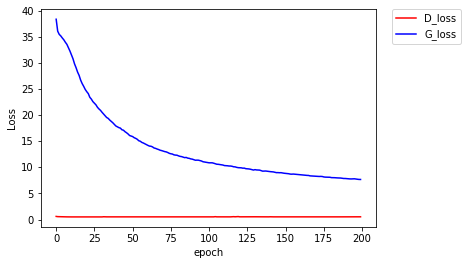

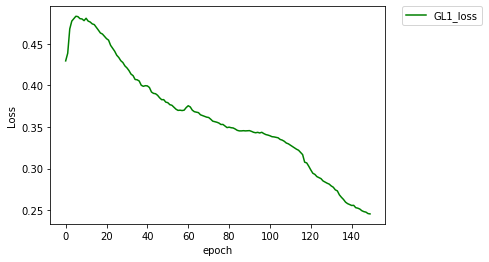

In [14]:
# Plot the loss

##########--WRITE YOUR CODE HERE--##########
plt.plot(D_loss , 'r', label= 'D_loss')
plt.plot(G_loss , 'b', label= 'G_loss')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

plt.plot(GL1_loss , 'g', label= 'GL1_loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

##########-------END OF CODE-------##########

### Part 5 Evaluation
---

Compared to a classification problem, evaluating an image translation model could be tricky because we don't always have the ground-truth available. There are several different ways to compare the performance of different GAN models:

1. Visualize the generated images of different GAN models. 

2. Compute a distance, such as **Frechet Inception Distance** (**FID**, the smaller the better, [paper](https://arxiv.org/abs/1706.08500)), between the generated images and the real images, or compute the Inception Score (**IS**, the higher the better, [paper](https://arxiv.org/pdf/1606.03498.pdf)) for the generated images. We strongly encourage you to read these papers.

3. Using generated images for downstream tasks, such as classification, segmentation, etc. and computing the task accuracy.

Now it's your turn to evaluate the models you trained. 

**{5 points}** We'll first visualize `4` test samples and plot them as in Figure 4 in the pix2pix paper, to get some qualitative results. You can select any interesting samples from the **test set**.

**{5 points}** Then let's do some quantitative analysis. Adapt this **Inception Score** ([ref](https://github.com/sbarratt/inception-score-pytorch/blob/master/inception_score.py)) implementation, and report the mean score of each model on the test set. Again, you are encouraged to train your models longer.

Sequence of the images are: Input, Groud truth, L1 loss, cGAN+L1


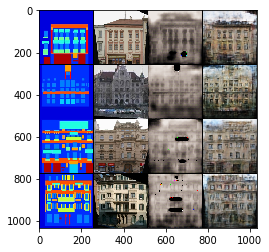

In [15]:
# Visualization
# Please read Figure 4 in the pix2pix paper first

##########--WRITE YOUR CODE HERE--##########
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torchvision
test_loader = DataLoader(dataset(root, "test"), 1, shuffle=True)
imgs = []
for j, (a, b) in enumerate(test_loader):
    a = a.to(device)
    b = b.to(device)
    with torch.no_grad():
        fake_b = netG(a)
        fake_b_l1 = netGL1(a)
    imgs += [a[0], b[0], fake_b_l1[0],fake_b[0]]
    if j == 3:
        break
imgs = torch.stack(imgs).detach().cpu()
save_image(imgs, "test/%s.png"%j, nrow=4, normalize=True)

# from IPython.display import Image, display
# im = PIL.Image.open('test/3.png')
# im.show()
# Image('test/3.png')
print('Sequence of the images are: Input, Groud truth, L1 loss, cGAN+L1')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
 # display it
img = mpimg.imread('test/3.png')
imgplot = plt.imshow(img)
plt.show()

# to_pil = torchvision.transforms.ToPILImage()
# img = to_pil(imgs)

##########-------END OF CODE-------##########

In [16]:
# Inception Scores
import torch
from torchvision.models.inception import inception_v3
from torch.autograd import Variable
import torch.utils.data
from scipy.stats import entropy
from torchvision.utils import save_image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
inception_model.eval();
up = nn.Upsample(size=(299, 299), mode='bilinear', align_corners=True).type(dtype)

def inception_score(images, splits=10):
    ##########--WRITE YOUR CODE HERE--##########
    batch_size = 1
    N = len(images)
    
    
#     assert batch_size > 0
#     assert N > batch_size
    
    # Set up dtype
    if device:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor
    
    dataloader = torch.utils.data.DataLoader(dataset(root, images), batch_size=batch_size)
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()
    # Get predictions
    preds = np.zeros((N, 1000))
    
    for i, batch in enumerate(dataloader, 0):
#         print( batch[1])
        batch = batch[1].type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]
        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)
        
    split_scores = []
    
    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    
    ##########-------END OF CODE-------##########
    return np.mean(split_scores)


# Get the translation on test set
##########--WRITE YOUR CODE HERE--##########

test_loader = DataLoader(dataset(root, "test"), 1, shuffle=True)
# imgs = []
# imgs_l1 = []
for j, (a, b) in enumerate(test_loader):
    a = a.to(device)
    b = b.to(device)
    with torch.no_grad():
        fake_b = netG(a)
        fake_b_l1 = netGL1(a)
#     imgs += [fake_b[0]]
#     imgs_l1 += [fake_b_l1[0]]
    save_image(fake_b, "facades/inception/%s.png"%j, normalize=True)
    save_image(fake_b_l1, "facades/inception_l1/%s.png"%j, normalize=True)



test_pred = 'inception/'
test_pred_l1 = 'inception_l1/'
##########-------END OF CODE-------##########

inception_s = inception_score(test_pred)
inception_s_l1 = inception_score(test_pred_l1)
print("IS for different losses, evaluated on facades dataset")
from IPython.display import HTML, display
import tabulate
table = [["Loss","IS ↑"],
         ["L1", f"{inception_s_l1:.4f}"],
         ["L1 + cGAN", f"{inception_s:.4f}"]]
display(HTML(tabulate.tabulate(table, tablefmt='html', headers="firstrow")))

/home/cou/muhammadmonjur.karim/anaconda3/envs/py37/lib/python3.7/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/cou/muhammadmonjur.karim/anaconda3/envs/py37/lib/python3.7/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/cou/muhammadmonjur.karim/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


IS for different losses, evaluated on facades dataset


Loss,IS ↑
L1,1
L1 + cGAN,1


### Part 6 Understanding pix2pix
---
#### {5 points}Problem 1  
What image sizes can Pix2pix train with, and why can it handle different image sizes?

Hint: Explain this based on the generator and discriminator architectures.

#### {5 points}Problem 2 

Given an input image with size $256\times256\times6$ for the discriminator, write down the size of each neuron's receptive field after each layer, using the **discriminator** network architectures above:

e.g. $$Input → C64 → (?) → C128 →(?) → C256 → (?) → C512 → (?)$$

**Make sure you calculate the receptive field, not the size of the image.**

#### {5 points}Problem 3
Explain why minimizing only the L1 loss results in a blurry image.


Euclidean distance between predicted and ground truth pixels, it will tend to produce blurry results [43, 62]. This is
because Euclidean distance is minimized by averaging all
plausible outputs, which causes blurring.


#### {5 points}Problem 4
Why do we use PatchGAN in Pix2pix? 


Answer: Problem 1:   Pix2pix can train any sizes of images. Because, after feeding one input image to the network it uses PatchGAN. This gives probabilities of two things, either real or fake, but not in scalar, it used NxN output vector. here, the NxN can be different depending on the dimension of an input image however each output vector prepresents the 70x70 patches/portion of an input image not the whole input image. That's why it can handle any size of images.

---

Answer:Problem 2:
The receptive field size are 4, 10, 22, 46 respectively. The calculation is given in the following Ipython line.
---

Answer:Problem 3: Because, only L1 loss measure the euclidean distance between predicted and ground truth pixels, which tends to produce blurry results. This is because Euclidean distance is minimized by averaging all plausible outputs, which causes blurring in the images.

---


Answer: Problem 4: To enforce high frequency correctness, PatchGAN is used, which penalizes a structure at the scale of patches. i.e. classifies NxN patches in an image is real or fake. D runs across the image like a convolution and all the responses are averaged.

---

In [17]:
#This is for calculating the receptive field size of the discriminator from the problem 2 of the above problem.

# [filter size, stride, padding]

convnet =[[4,2,1],[4,2,1],[4,2,1],[4,2,1]]
layer_name = ['conv1','conv2','conv3','conv4']
# layer_name = ['conv1','pool1','conv2','pool2','conv3','conv4','conv5','pool5','fc6-conv']
imsize = 256

def outFromIn(isz, layernum = 6, net = convnet):
    if layernum>len(net): layernum=len(net)

    totstride = 1
    insize = isz
    #for layerparams in net:
    for layer in range(layernum):
        fsize, stride, pad = net[layer]
        outsize = (insize - fsize + 2*pad) / stride + 1
        insize = outsize
        totstride = totstride * stride
    return outsize, totstride

def inFromOut( layernum = 9, net = convnet):
    if layernum>len(net): layernum=len(net)
    outsize = 1
    #for layerparams in net:
    for layer in reversed(range(layernum)):
        fsize, stride, pad = net[layer]
        outsize = ((outsize -1)* stride) + fsize
    RFsize = outsize
    return RFsize

print ("layer output sizes given image = %dx%d" % (imsize, imsize))
for i in range(len(convnet)):
    p = outFromIn(imsize,i+1)
    rf = inFromOut(i+1)
    print ("Layer Name = %s, Output size = %3d, Stride = % 3d, RF size = %3d" % (layer_name[i], p[0], p[1], rf))

layer output sizes given image = 256x256
Layer Name = conv1, Output size = 128, Stride =   2, RF size =   4
Layer Name = conv2, Output size =  64, Stride =   4, RF size =  10
Layer Name = conv3, Output size =  32, Stride =   8, RF size =  22
Layer Name = conv4, Output size =  16, Stride =  16, RF size =  46


### {10 points} Bonus: Spectral Normalization

Spectral normalization (**SN**, [paper](https://arxiv.org/abs/1802.05957)) is a simple and useful technique for stabilizing GAN training. Replace `batch normalization` with `spectral normalization` in both discriminator and generator, train the new model with the same L1 and cGAN loss for at least 20 epochs, then save the model to `pix2pixSN.pth`. Finally, perform the same evaluation you did in part 5 and compare the performance of all the models you trained.

Hint: use `torch.nn.utils.spectral_norm`.


In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [19]:
# discriminator
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

class Discriminator(nn.Module):
    def __init__(self, n_channels):
        # n_channels means num of input channels
        super(Discriminator, self).__init__()
        ##########--WRITE YOUR CODE HERE--##########
        d = 64
        self.conv1 = nn.Conv2d(n_channels*2, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv3 = torch.nn.utils.spectral_norm(nn.Conv2d(d * 2, d * 4, 4, 2, 1))
        self.conv4 = torch.nn.utils.spectral_norm(nn.Conv2d(d * 4, d * 8, 4, 1, 1))
        self.conv5 = torch.nn.utils.spectral_norm(nn.Conv2d(d * 8, 1, 4, 1, 1))
        

        ##########-------END OF CODE-------##########
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
        
    def forward(self, inpu, label):
        ##########--WRITE YOUR CODE HERE--##########
        x = torch.cat([inpu, label], 1)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu((self.conv2(x)), 0.2)
        x = F.leaky_relu((self.conv3(x)), 0.2)
        x = F.leaky_relu((self.conv4(x)), 0.2)
        x_d = F.sigmoid(self.conv5(x))        
        ##########-------END OF CODE-------##########
        return x_d

##########--WRITE YOUR CODE HERE--##########    
# netD = # initialize the discriminator
netD = Discriminator(3)
# feel free to do some sanity check here

##########-------END OF CODE-------##########    


In [20]:
from torch.nn.utils import spectral_norm

class ConvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, activation=True, spectral_norm=False):
        super(ConvBlock, self).__init__()
        self.conv = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding)
        self.activation = activation
        self.lrelu = torch.nn.LeakyReLU(0.2, True)
        self.spectral_norm = spectral_norm
#         self.batch_norm = batch_norm
#         self.bn = torch.nn.BatchNorm2d(output_size)
        
    def forward(self, x):
        if self.activation:
            out = self.conv(self.lrelu(x))
        else:
            out = self.conv(x)
            
        return out
        

        
class DeconvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, batch_norm=True, dropout=False):
        super(DeconvBlock, self).__init__()
        self.deconv = torch.nn.ConvTranspose2d(input_size, output_size, kernel_size, stride, padding)
#         self.bn = torch.nn.BatchNorm2d(output_size)
        self.drop = torch.nn.Dropout(0.5)
        self.relu = torch.nn.ReLU(True)
        self.spectral_norm = spectral_norm
        self.dropout = dropout

    def forward(self, x):
        out = self.deconv(self.relu(x))
#         if self.batch_norm:
#             out = self.bn(self.deconv(self.relu(x)))
#         else:
#             out = self.deconv(self.relu(x))

        if self.dropout:
            return self.drop(out)
        else:
            return out
        
class Generator(torch.nn.Module):
    def __init__(self, input_dim, num_filter, output_dim):
        super(Generator, self).__init__()

        # Encoder
        self.conv1 = ConvBlock(input_dim, num_filter, activation=False, spectral_norm=False)
        self.conv2 = ConvBlock(num_filter, num_filter * 2)
        self.conv3 = ConvBlock(num_filter * 2, num_filter * 4)
        self.conv4 = ConvBlock(num_filter * 4, num_filter * 8)
        self.conv5 = ConvBlock(num_filter * 8, num_filter * 8)
        self.conv6 = ConvBlock(num_filter * 8, num_filter * 8)
        self.conv7 = ConvBlock(num_filter * 8, num_filter * 8)
        self.conv8 = ConvBlock(num_filter * 8, num_filter * 8, spectral_norm=False)
        # Decoder
        self.deconv1 = DeconvBlock(num_filter * 8, num_filter * 8, dropout=True)
        self.deconv2 = DeconvBlock(num_filter * 8 * 2, num_filter * 8, dropout=True)
        self.deconv3 = DeconvBlock(num_filter * 8 * 2, num_filter * 8, dropout=True)
        self.deconv4 = DeconvBlock(num_filter * 8 * 2, num_filter * 8)
        self.deconv5 = DeconvBlock(num_filter * 8 * 2, num_filter * 4)
        self.deconv6 = DeconvBlock(num_filter * 4 * 2, num_filter * 2)
        self.deconv7 = DeconvBlock(num_filter * 2 * 2, num_filter)
        self.deconv8 = DeconvBlock(num_filter * 2, output_dim)

    def forward(self, x):
        # Encoder
        enc1 = self.conv1(x)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        enc4 = self.conv4(enc3)
        enc5 = self.conv5(enc4)
        enc6 = self.conv6(enc5)
        enc7 = self.conv7(enc6)
        enc8 = self.conv8(enc7)
        # Decoder with skip-connections
        dec1 = self.deconv1(enc8)
        dec1 = torch.cat([dec1, enc7], 1)
        dec2 = self.deconv2(dec1)
        dec2 = torch.cat([dec2, enc6], 1)
        dec3 = self.deconv3(dec2)
        dec3 = torch.cat([dec3, enc5], 1)
        dec4 = self.deconv4(dec3)
        dec4 = torch.cat([dec4, enc4], 1)
        dec5 = self.deconv5(dec4)
        dec5 = torch.cat([dec5, enc3], 1)
        dec6 = self.deconv6(dec5)
        dec6 = torch.cat([dec6, enc2], 1)
        dec7 = self.deconv7(dec6)
        dec7 = torch.cat([dec7, enc1], 1)
        dec8 = self.deconv8(dec7)
        out = torch.nn.Tanh()(dec8)
        return out
    
netG = Generator(3,64, 3)
netGL1 = Generator(3,64, 3)

In [21]:
# Define the optimizors here, make sure you give them the right parameters

##########--WRITE YOUR CODE HERE--########## 
optim_G = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_D = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_GL1 = optim.Adam(netGL1.parameters(), lr=0.0002, betas=(0.5, 0.999))

##########-------END OF CODE-------##########

In [22]:
from torchvision.utils import save_image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

netG = netG.to(device)
netD = netD.to(device)
netG.train()
netD.train()

##########--WRITE YOUR CODE HERE--########## 
def train_model(netG, netD, optim_G, optim_D, train_loader, val_loader, epoch):
#     netG.train()
#     netD.train()

    G_loss, D_loss = [], []
    gan_loss = F.binary_cross_entropy_with_logits

    for i, (a, b) in enumerate(train_loader):

        a = a.to(device)
        b = b.to(device)

        real = torch.ones((a.size(0), 1, 30, 30)).to(device)
        fake = torch.zeros((a.size(0), 1, 30, 30)).to(device)

        # update generator

        optim_G.zero_grad()

        fake_b = netG(a)
        pred = netD(a, fake_b)

        loss_G = gan_loss(pred, real) + F.l1_loss(b, fake_b) * 100

        loss_G.backward()
        optim_G.step()

        # update discriminator

        optim_D.zero_grad()

        pred_real = netD(a, b)
        loss_real = gan_loss(pred_real, real)

        pred_fake = netD(a, fake_b.detach())
        loss_fake = gan_loss(pred_fake, fake)

        loss_D = (loss_real + loss_fake) * 0.5

        loss_D.backward()
        optim_D.step()

        G_loss.append(loss_G.item())
        D_loss.append(loss_D.item())

        if (i+1) % 10 == 0:
            g_mean = np.mean(G_loss[-10:])
            d_mean = np.mean(D_loss[-10:])
            print("\rEpoch %d [%d/%d] [G loss: %f] [D loss: %f]" %
                    (epoch, i, len(train_loader), g_mean, d_mean))

        iters = epoch * len(train_loader) + i
        if iters % 500 == 0:
            imgs = []
            for j, (a, b) in enumerate(val_loader):
                a = a.to(device)
                b = b.to(device)
                with torch.no_grad():
                    fake_b = netG(a)
                imgs += [a[0], fake_b[0], b[0]]
                if j == 2:
                    break
            imgs = torch.stack(imgs).detach().cpu()
            save_image(imgs, "images_spectral/%s.png"%iters, nrow=3, normalize=True)

    return np.mean(G_loss), np.mean(D_loss)

#performing training
epochs = 20
G_losses = []
D_losses =[]
for epoch in range(epochs):
        G_loss, D_loss = train_model(netG, netD, optim_G, optim_D, train_loader, val_loader, epoch)

        print('\nG_loss: %.4f	D_loss: %.4f\n'%(G_loss, D_loss))
        G_losses.append(G_loss)
        D_losses.append(D_loss)

        with open('log_spectral.txt', 'a') as f:
            print('%d\t%.4f\t%.4f'%(epoch, G_loss, D_loss), file=f)

##########-------END OF CODE-------##########

/home/cou/muhammadmonjur.karim/anaconda3/envs/py37/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0 [9/400] [G loss: 47.974587] [D loss: 0.688611]
Epoch 0 [19/400] [G loss: 39.172392] [D loss: 0.690043]
Epoch 0 [29/400] [G loss: 45.606370] [D loss: 0.670833]
Epoch 0 [39/400] [G loss: 38.082350] [D loss: 0.692355]
Epoch 0 [49/400] [G loss: 40.555670] [D loss: 0.676609]
Epoch 0 [59/400] [G loss: 38.226572] [D loss: 0.620936]
Epoch 0 [69/400] [G loss: 42.161230] [D loss: 0.536037]
Epoch 0 [79/400] [G loss: 38.989694] [D loss: 0.536697]
Epoch 0 [89/400] [G loss: 38.014047] [D loss: 0.548124]
Epoch 0 [99/400] [G loss: 38.232105] [D loss: 0.535079]
Epoch 0 [109/400] [G loss: 40.341318] [D loss: 0.544637]
Epoch 0 [119/400] [G loss: 39.478689] [D loss: 0.553130]
Epoch 0 [129/400] [G loss: 40.436805] [D loss: 0.556737]
Epoch 0 [139/400] [G loss: 37.043786] [D loss: 0.574497]
Epoch 0 [149/400] [G loss: 40.899832] [D loss: 0.532611]
Epoch 0 [159/400] [G loss: 36.018385] [D loss: 0.582520]
Epoch 0 [169/400] [G loss: 38.732200] [D loss: 0.594156]
Epoch 0 [179/400] [G loss: 37.636593] [D l

Epoch 3 [239/400] [G loss: 32.999393] [D loss: 0.519883]
Epoch 3 [249/400] [G loss: 36.450524] [D loss: 0.511478]
Epoch 3 [259/400] [G loss: 37.122747] [D loss: 0.514944]
Epoch 3 [269/400] [G loss: 31.542834] [D loss: 0.513412]
Epoch 3 [279/400] [G loss: 37.208259] [D loss: 0.512655]
Epoch 3 [289/400] [G loss: 38.867285] [D loss: 0.507888]
Epoch 3 [299/400] [G loss: 37.267066] [D loss: 0.582625]
Epoch 3 [309/400] [G loss: 35.775961] [D loss: 0.591910]
Epoch 3 [319/400] [G loss: 33.938274] [D loss: 0.565517]
Epoch 3 [329/400] [G loss: 34.765440] [D loss: 0.521185]
Epoch 3 [339/400] [G loss: 36.390475] [D loss: 0.508935]
Epoch 3 [349/400] [G loss: 33.308690] [D loss: 0.510606]
Epoch 3 [359/400] [G loss: 33.574604] [D loss: 0.511395]
Epoch 3 [369/400] [G loss: 37.079136] [D loss: 0.512729]
Epoch 3 [379/400] [G loss: 37.670288] [D loss: 0.548843]
Epoch 3 [389/400] [G loss: 37.547072] [D loss: 0.513143]
Epoch 3 [399/400] [G loss: 32.820739] [D loss: 0.518568]

G_loss: 35.2924	D_loss: 0.5215

Epoch 7 [69/400] [G loss: 37.035755] [D loss: 0.506329]
Epoch 7 [79/400] [G loss: 34.917663] [D loss: 0.505430]
Epoch 7 [89/400] [G loss: 35.710163] [D loss: 0.509223]
Epoch 7 [99/400] [G loss: 32.514324] [D loss: 0.513735]
Epoch 7 [109/400] [G loss: 35.168884] [D loss: 0.511243]
Epoch 7 [119/400] [G loss: 31.339692] [D loss: 0.506208]
Epoch 7 [129/400] [G loss: 31.072623] [D loss: 0.506482]
Epoch 7 [139/400] [G loss: 37.638321] [D loss: 0.509479]
Epoch 7 [149/400] [G loss: 32.858555] [D loss: 0.509146]
Epoch 7 [159/400] [G loss: 35.113022] [D loss: 0.510821]
Epoch 7 [169/400] [G loss: 32.494390] [D loss: 0.505628]
Epoch 7 [179/400] [G loss: 34.011829] [D loss: 0.503746]
Epoch 7 [189/400] [G loss: 38.784872] [D loss: 0.514415]
Epoch 7 [199/400] [G loss: 31.241146] [D loss: 0.516475]
Epoch 7 [209/400] [G loss: 31.033295] [D loss: 0.514480]
Epoch 7 [219/400] [G loss: 33.348451] [D loss: 0.509792]
Epoch 7 [229/400] [G loss: 30.851348] [D loss: 0.506191]
Epoch 7 [239/400] [G loss: 34.19710

Epoch 10 [299/400] [G loss: 36.072356] [D loss: 0.506797]
Epoch 10 [309/400] [G loss: 31.250549] [D loss: 0.511569]
Epoch 10 [319/400] [G loss: 29.113637] [D loss: 0.508500]
Epoch 10 [329/400] [G loss: 31.672556] [D loss: 0.509616]
Epoch 10 [339/400] [G loss: 31.875758] [D loss: 0.509818]
Epoch 10 [349/400] [G loss: 32.754139] [D loss: 0.507312]
Epoch 10 [359/400] [G loss: 30.125373] [D loss: 0.509919]
Epoch 10 [369/400] [G loss: 36.027976] [D loss: 0.507162]
Epoch 10 [379/400] [G loss: 32.179180] [D loss: 0.506231]
Epoch 10 [389/400] [G loss: 31.167441] [D loss: 0.509875]
Epoch 10 [399/400] [G loss: 28.729392] [D loss: 0.511189]

G_loss: 32.1092	D_loss: 0.5108

Epoch 11 [9/400] [G loss: 28.786822] [D loss: 0.516038]
Epoch 11 [19/400] [G loss: 32.366147] [D loss: 0.509310]
Epoch 11 [29/400] [G loss: 29.232446] [D loss: 0.509445]
Epoch 11 [39/400] [G loss: 26.405037] [D loss: 0.514893]
Epoch 11 [49/400] [G loss: 32.101049] [D loss: 0.514161]
Epoch 11 [59/400] [G loss: 30.479772] [D loss

Epoch 14 [99/400] [G loss: 27.920043] [D loss: 0.511873]
Epoch 14 [109/400] [G loss: 29.433016] [D loss: 0.508660]
Epoch 14 [119/400] [G loss: 27.047078] [D loss: 0.507274]
Epoch 14 [129/400] [G loss: 29.545420] [D loss: 0.505932]
Epoch 14 [139/400] [G loss: 26.799780] [D loss: 0.510873]
Epoch 14 [149/400] [G loss: 26.688215] [D loss: 0.508998]
Epoch 14 [159/400] [G loss: 29.421367] [D loss: 0.507864]
Epoch 14 [169/400] [G loss: 27.092212] [D loss: 0.518763]
Epoch 14 [179/400] [G loss: 26.782446] [D loss: 0.509957]
Epoch 14 [189/400] [G loss: 25.011302] [D loss: 0.525351]
Epoch 14 [199/400] [G loss: 28.302062] [D loss: 0.510847]
Epoch 14 [209/400] [G loss: 26.656880] [D loss: 0.511706]
Epoch 14 [219/400] [G loss: 26.503467] [D loss: 0.509217]
Epoch 14 [229/400] [G loss: 26.873505] [D loss: 0.510454]
Epoch 14 [239/400] [G loss: 28.135857] [D loss: 0.518993]
Epoch 14 [249/400] [G loss: 26.155093] [D loss: 0.509393]
Epoch 14 [259/400] [G loss: 31.648771] [D loss: 0.507292]
Epoch 14 [269/4

Epoch 17 [309/400] [G loss: 26.269012] [D loss: 0.506158]
Epoch 17 [319/400] [G loss: 26.348143] [D loss: 0.510868]
Epoch 17 [329/400] [G loss: 26.713073] [D loss: 0.520618]
Epoch 17 [339/400] [G loss: 23.448316] [D loss: 0.516083]
Epoch 17 [349/400] [G loss: 27.681442] [D loss: 0.508935]
Epoch 17 [359/400] [G loss: 27.436166] [D loss: 0.505023]
Epoch 17 [369/400] [G loss: 26.169731] [D loss: 0.517680]
Epoch 17 [379/400] [G loss: 27.379475] [D loss: 0.506810]
Epoch 17 [389/400] [G loss: 24.159414] [D loss: 0.518902]
Epoch 17 [399/400] [G loss: 26.762098] [D loss: 0.506298]

G_loss: 25.8083	D_loss: 0.5105

Epoch 18 [9/400] [G loss: 23.861203] [D loss: 0.520224]
Epoch 18 [19/400] [G loss: 25.880277] [D loss: 0.507164]
Epoch 18 [29/400] [G loss: 27.169069] [D loss: 0.509882]
Epoch 18 [39/400] [G loss: 21.389156] [D loss: 0.511612]
Epoch 18 [49/400] [G loss: 21.374986] [D loss: 0.513290]
Epoch 18 [59/400] [G loss: 25.982929] [D loss: 0.528416]
Epoch 18 [69/400] [G loss: 25.680205] [D loss:

In [23]:
netGL1 = netGL1.to(device)
netGL1.train()

##########--WRITE YOUR CODE HERE--########## 
def train_model(netGL1, optim_G, train_loader, val_loader, epoch):
#     netG.train()
#     netD.train()

    GL1_loss = []
#     gan_loss = F.binary_cross_entropy_with_logits

    for i, (a, b) in enumerate(train_loader):

        a = a.to(device)
        b = b.to(device)

        real = torch.ones((a.size(0), 1, 30, 30)).to(device)
        fake = torch.zeros((a.size(0), 1, 30, 30)).to(device)

        # update generator

        optim_G.zero_grad()

        fake_b = netGL1(a)
#         pred = netD(a, fake_b)

#         loss_G = gan_loss(pred, real) + F.l1_loss(b, fake_b) * 100
        loss_G = F.l1_loss(b, fake_b)

        loss_G.backward()
        optim_GL1.step()


        GL1_loss.append(loss_G.item())
#         D_loss.append(loss_D.item())

        if (i+1) % 10 == 0:
            g_mean = np.mean(GL1_loss[-10:])
            print("\rEpoch %d [%d/%d] [GL1 loss: %f]" %
                    (epoch, i, len(train_loader), g_mean))

        iters = epoch * len(train_loader) + i
        if iters % 500 == 0:
            imgs = []
            for j, (a, b) in enumerate(val_loader):
                a = a.to(device)
                b = b.to(device)
                with torch.no_grad():
                    fake_b = netGL1(a)
                imgs += [a[0], fake_b[0], b[0]]
                if j == 2:
                    break
            imgs = torch.stack(imgs).detach().cpu()
            save_image(imgs, "images_l1_sepctral/%s.png"%iters, nrow=3, normalize=True)

    return np.mean(GL1_loss)

epoch_l1 = 15
GL1_losses = []
for epoch in range(epoch_l1):
        GL1_loss = train_model(netGL1, optim_G, train_loader, val_loader, epoch)

        print('\nGL1_loss: %.4f \n'%(GL1_loss))
        GL1_losses.append(GL1_loss)

        with open('logL1_spectral.txt', 'a') as f:
            print('%d\t%.4f\t'%(epoch, GL1_loss), file=f)


##########-------END OF CODE-------##########

Epoch 0 [9/400] [GL1 loss: 0.509963]
Epoch 0 [19/400] [GL1 loss: 0.461833]
Epoch 0 [29/400] [GL1 loss: 0.415278]
Epoch 0 [39/400] [GL1 loss: 0.395559]
Epoch 0 [49/400] [GL1 loss: 0.444634]
Epoch 0 [59/400] [GL1 loss: 0.403627]
Epoch 0 [69/400] [GL1 loss: 0.416643]
Epoch 0 [79/400] [GL1 loss: 0.357673]
Epoch 0 [89/400] [GL1 loss: 0.381876]
Epoch 0 [99/400] [GL1 loss: 0.382070]
Epoch 0 [109/400] [GL1 loss: 0.395479]
Epoch 0 [119/400] [GL1 loss: 0.349107]
Epoch 0 [129/400] [GL1 loss: 0.360619]
Epoch 0 [139/400] [GL1 loss: 0.402512]
Epoch 0 [149/400] [GL1 loss: 0.394302]
Epoch 0 [159/400] [GL1 loss: 0.406683]
Epoch 0 [169/400] [GL1 loss: 0.408501]
Epoch 0 [179/400] [GL1 loss: 0.366037]
Epoch 0 [189/400] [GL1 loss: 0.386911]
Epoch 0 [199/400] [GL1 loss: 0.359616]
Epoch 0 [209/400] [GL1 loss: 0.418076]
Epoch 0 [219/400] [GL1 loss: 0.410705]
Epoch 0 [229/400] [GL1 loss: 0.359012]
Epoch 0 [239/400] [GL1 loss: 0.436689]
Epoch 0 [249/400] [GL1 loss: 0.426533]
Epoch 0 [259/400] [GL1 loss: 0.39793

Epoch 5 [109/400] [GL1 loss: 0.902825]
Epoch 5 [119/400] [GL1 loss: 0.938902]
Epoch 5 [129/400] [GL1 loss: 0.947133]
Epoch 5 [139/400] [GL1 loss: 0.952761]
Epoch 5 [149/400] [GL1 loss: 0.922825]
Epoch 5 [159/400] [GL1 loss: 0.921757]
Epoch 5 [169/400] [GL1 loss: 0.943465]
Epoch 5 [179/400] [GL1 loss: 0.932996]
Epoch 5 [189/400] [GL1 loss: 0.928567]
Epoch 5 [199/400] [GL1 loss: 0.938504]
Epoch 5 [209/400] [GL1 loss: 0.927992]
Epoch 5 [219/400] [GL1 loss: 0.935569]
Epoch 5 [229/400] [GL1 loss: 0.943822]
Epoch 5 [239/400] [GL1 loss: 0.942368]
Epoch 5 [249/400] [GL1 loss: 0.882361]
Epoch 5 [259/400] [GL1 loss: 0.937440]
Epoch 5 [269/400] [GL1 loss: 0.909970]
Epoch 5 [279/400] [GL1 loss: 0.904087]
Epoch 5 [289/400] [GL1 loss: 0.893371]
Epoch 5 [299/400] [GL1 loss: 0.870823]
Epoch 5 [309/400] [GL1 loss: 0.916390]
Epoch 5 [319/400] [GL1 loss: 0.906817]
Epoch 5 [329/400] [GL1 loss: 0.890597]
Epoch 5 [339/400] [GL1 loss: 0.933639]
Epoch 5 [349/400] [GL1 loss: 0.952648]
Epoch 5 [359/400] [GL1 lo

Epoch 10 [199/400] [GL1 loss: 0.841074]
Epoch 10 [209/400] [GL1 loss: 0.929897]
Epoch 10 [219/400] [GL1 loss: 0.926386]
Epoch 10 [229/400] [GL1 loss: 0.943157]
Epoch 10 [239/400] [GL1 loss: 0.989190]
Epoch 10 [249/400] [GL1 loss: 0.954332]
Epoch 10 [259/400] [GL1 loss: 0.873942]
Epoch 10 [269/400] [GL1 loss: 0.893173]
Epoch 10 [279/400] [GL1 loss: 0.947735]
Epoch 10 [289/400] [GL1 loss: 0.898375]
Epoch 10 [299/400] [GL1 loss: 0.932797]
Epoch 10 [309/400] [GL1 loss: 0.901316]
Epoch 10 [319/400] [GL1 loss: 0.924188]
Epoch 10 [329/400] [GL1 loss: 0.894863]
Epoch 10 [339/400] [GL1 loss: 0.963117]
Epoch 10 [349/400] [GL1 loss: 0.948380]
Epoch 10 [359/400] [GL1 loss: 0.945450]
Epoch 10 [369/400] [GL1 loss: 0.956589]
Epoch 10 [379/400] [GL1 loss: 0.927337]
Epoch 10 [389/400] [GL1 loss: 0.960567]
Epoch 10 [399/400] [GL1 loss: 0.871629]

GL1_loss: 0.9197 

Epoch 11 [9/400] [GL1 loss: 0.914583]
Epoch 11 [19/400] [GL1 loss: 0.874914]
Epoch 11 [29/400] [GL1 loss: 0.926472]
Epoch 11 [39/400] [GL1 l

In [24]:
# codes for saving models, feel free to change them

torch.save({
    'G': netG.state_dict(),
    'D': netD.state_dict(),
    'epoch': epochs,
    'loss_G': G_losses,
    'loss_D': D_losses,
    }, 'pix2pix_spectral.pth')

torch.save({
    'G': netGL1.state_dict(),
    'epoch': epoch_l1,
    'loss': GL1_losses,
    }, 'pix2pixL1_spectral.pth')


In [25]:
# codes for restoring models, feel free to change them

path = "pix2pix_spectral.pth"
checkpoint = torch.load(path)
netG.load_state_dict(checkpoint['G'])
netD.load_state_dict(checkpoint['D'])
epoch = checkpoint['epoch']
G_loss = checkpoint['loss_G']
D_loss = checkpoint['loss_D']

path = "pix2pixL1_spectral.pth"
checkpoint = torch.load(path)
netGL1.load_state_dict(checkpoint['G'])
epoch_l1 = checkpoint['epoch']
GL1_loss = checkpoint['loss']

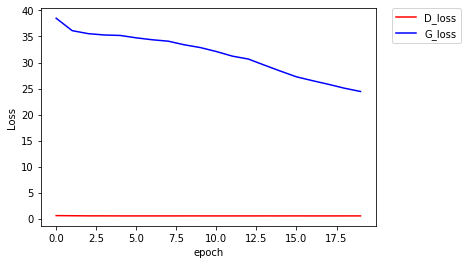

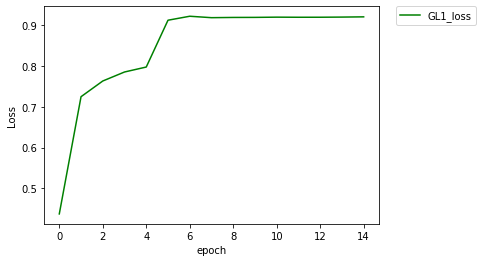

In [26]:
# Plot the loss

##########--WRITE YOUR CODE HERE--##########
plt.plot(D_loss , 'r', label= 'D_loss')
plt.plot(G_loss , 'b', label= 'G_loss')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

plt.plot(GL1_loss , 'g', label= 'GL1_loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

##########-------END OF CODE-------##########

Sequence of the images are: Input, Groud truth, L1 loss, cGAN+L1


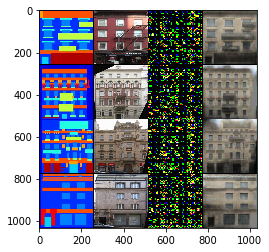

In [27]:
# Visualization
# Please read Figure 4 in the pix2pix paper first

##########--WRITE YOUR CODE HERE--##########
import torchvision
test_loader = DataLoader(dataset(root, "test"), 1, shuffle=True)
imgs = []
for j, (a, b) in enumerate(test_loader):
    a = a.to(device)
    b = b.to(device)
    with torch.no_grad():
        fake_b = netG(a)
        fake_b_l1 = netGL1(a)
    imgs += [a[0], b[0], fake_b_l1[0],fake_b[0]]
    if j == 3:
        break
imgs = torch.stack(imgs).detach().cpu()
save_image(imgs, "test_spectral/%s.png"%j, nrow=4, normalize=True)

print('Sequence of the images are: Input, Groud truth, L1 loss, cGAN+L1')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
 # display it
img = mpimg.imread('test_spectral/3.png')
imgplot = plt.imshow(img)
plt.show()
# print('Sequence of the images are: Input, Groud truth, L1 loss, cGAN+L1')

# to_pil = torchvision.transforms.ToPILImage()
# img = to_pil(imgs)

##########-------END OF CODE-------##########

In [28]:
# Inception Scores
import torch
from torchvision.models.inception import inception_v3
from torch.autograd import Variable
import torch.utils.data
from scipy.stats import entropy
from torchvision.utils import save_image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
inception_model.eval();
up = nn.Upsample(size=(299, 299), mode='bilinear', align_corners=True).type(dtype)

def inception_score(images, splits=10):
    ##########--WRITE YOUR CODE HERE--##########
    batch_size = 1
    N = len(images)
    
    
#     assert batch_size > 0
#     assert N > batch_size
    
    # Set up dtype
    if device:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor
    
    dataloader = torch.utils.data.DataLoader(dataset(root, images), batch_size=batch_size)
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()
    # Get predictions
    preds = np.zeros((N, 1000))
    
    for i, batch in enumerate(dataloader, 0):
#         print( batch[1])
        batch = batch[1].type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]
        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)
        
    split_scores = []
    
    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    
    ##########-------END OF CODE-------##########
    return np.mean(split_scores)


# Get the translation on test set
##########--WRITE YOUR CODE HERE--##########

test_loader = DataLoader(dataset(root, "test"), 1, shuffle=True)
# imgs = []
# imgs_l1 = []
for j, (a, b) in enumerate(test_loader):
    a = a.to(device)
    b = b.to(device)
    with torch.no_grad():
        fake_b = netG(a)
        fake_b_l1 = netGL1(a)
#     imgs += [fake_b[0]]
#     imgs_l1 += [fake_b_l1[0]]
    save_image(fake_b, "facades/inception_spec/%s.png"%j, normalize=True)
    save_image(fake_b_l1, "facades/inception_l1_spec/%s.png"%j, normalize=True)



test_pred = 'inception_spec/'
test_pred_l1 = 'inception_l1_spec/'
##########-------END OF CODE-------##########

inception_s = inception_score(test_pred)
inception_s_l1 = inception_score(test_pred_l1)
print("IS for different losses, evaluated on facades dataset")
from IPython.display import HTML, display
import tabulate
table = [["Loss","IS ↑"],
         ["L1", f"{inception_s_l1:.4f}"],
         ["L1 + cGAN", f"{inception_s:.4f}"]]
display(HTML(tabulate.tabulate(table, tablefmt='html', headers="firstrow")))

/home/cou/muhammadmonjur.karim/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


IS for different losses, evaluated on facades dataset


Loss,IS ↑
L1,1
L1 + cGAN,1


## Submission guidelines
---
Your need to submit a single zip file to Blackboard described as follow.

Please generate a pdf file that includes a ***google shared link*** (explained in the next paragraph). This pdf file should be named as ***Surname_Givenname_SBUID_hw*\*.pdf** (example: Jordan_Michael_111234567_hw5.pdf for this assignment).

To generate the ***google shared link***, first create a folder named ***Surname_Givenname_SBUID_hw**** in your Google Drive with your Stony Brook account. The structure of the files in the folder should be exactly the same as the one you downloaded. For instance in this homework:

```
Surname_Givenname_SBUID_hw5
        |---facades/
        |---pix2pix.pth
        |---pix2pixL1.pth
        |---CSE527-HW5-fall20.ipynb
        |---download_dataset.sh
```
Note that this folder should be in your Google Drive with your Stony Brook account.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter the TA's email: ***xiang.li.7@stonybrook.edu***. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **UNCHECK** the **Notify people** box.

Note that in google colab, we will only grade the version of the code right before the timestamp of the submission made in blackboard. 

To submit to Blackboard, zip ***Surname_Givenname_SBUID_hw*\*.pdf** and ***Surname_Givenname_SBUID_hw**** folder together and name your zip file as ***Surname_Givenname_SBUID_hw*\*.zip**. 

The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw5' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs.


-- DO NOT change the folder structure, please just fill in the blanks. <br>

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be delays in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have 4 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penalty will be imposed if not using the grace period.
